<a href="https://colab.research.google.com/github/sthomas522/HF_agents/blob/main/experiments/GenAI_Final_Project_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full bot

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install huggingface_hub[hf_xet]
#!pip install --upgrade tensorflow
!pip install --upgrade bitsandbytes
!pip install --upgrade langchain_openai langchain_core langgraph SPARQLWrapper
!pip install --upgrade duckduckgo-search wikipedia wikipedia-api duckduckgo-search
!pip install --upgrade opencv-python yt-dlp pytube
!pip install --upgrade langchain_huggingface langchain_community datasets gradio
!pip install --upgrade pillow spacy librosa
!pip install sentence-transformers
!pip install langchain faiss-cpu
!pip install pyppeteer
!pip install ipdb
!pip install beautifulsoup4


Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s e

In [3]:
import os
import re
import tempfile
from typing import TypedDict, List, Optional, Dict, Any
import string

import cv2
import requests
import wikipedia
from PIL import Image
import torch
import glob
import shutil

from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WikipediaLoader
from langchain_huggingface import HuggingFaceEndpoint
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage # If you are using it
from langchain_community.retrievers import BM25Retriever # If you are using it
from langgraph.prebuilt import ToolNode, tools_condition # If you are using it
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline

import spacy
import yt_dlp
from io import BytesIO
from duckduckgo_search import DDGS
import librosa
from sentence_transformers import SentenceTransformer

#from tools import * # Assuming this file is in a location accessible from the current directory or you've set up the correct import path.

In [4]:
nlp = spacy.load("en_core_web_sm")


In [5]:
# Define file extension sets for each category
PICTURE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
AUDIO_EXTENSIONS = {'.mp3', '.wav', '.aac', '.flac', '.ogg', '.m4a', '.wma'}
CODE_EXTENSIONS = {'.py', '.js', '.java', '.cpp', '.c', '.cs', '.rb', '.go', '.php', '.html', '.css', '.ts'}
SPREADSHEET_EXTENSIONS = {
    '.xls', '.xlsx', '.xlsm', '.xlsb', '.xlt', '.xltx', '.xltm',
    '.ods', '.ots', '.csv', '.tsv', '.sxc', '.stc', '.dif', '.gsheet',
    '.numbers', '.numbers-tef', '.nmbtemplate', '.fods', '.123', '.wk1', '.wk2',
    '.wks', '.wku', '.wr1', '.gnumeric', '.gnm', '.xml', '.pmvx', '.pmdx',
    '.pmv', '.uos', '.txt'
}

def get_file_type(filename: str) -> str:
    if not filename or '.' not in filename or filename == '':
        return ''
    ext = filename.lower().rsplit('.', 1)[-1]
    dot_ext = f'.{ext}'
    if dot_ext in PICTURE_EXTENSIONS:
        return 'picture'
    elif dot_ext in AUDIO_EXTENSIONS:
        return 'audio'
    elif dot_ext in CODE_EXTENSIONS:
        return 'code'
    elif dot_ext in SPREADSHEET_EXTENSIONS:
        return 'spreadsheet'
    else:
        return 'unknown'

In [6]:
def write_bytes_to_temp_dir(file_bytes: bytes, file_name: str) -> str:
    """
    Writes bytes to a file in the system temporary directory using the provided file_name.
    Returns the full path to the saved file.
    The file will persist until manually deleted or the OS cleans the temp directory.
    """
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(file_bytes)
    print(f"File written to: {file_path}")
    return file_path


In [7]:
DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"

api_url = DEFAULT_API_URL
questions_url = f"{api_url}/questions"
submit_url = f"{api_url}/submit"
files_url = f"{api_url}/files"

print(f"Fetching questions from: {questions_url}")
response = requests.get(questions_url, timeout=15)
response.raise_for_status()
hf_questions = response.json()

# Send GET request
response = requests.get(questions_url)

# Check if the request was successful
if response.status_code == 200:
    questions = response.json()
    print(questions)
else:
    print(f"Failed to retrieve questions. Status code: {response.status_code}")
    print(response.text)


questions = [item['question'] for item in response.json()]

# full details
hf_questions = response.json()

for item in hf_questions:
    file_name = item.get('file_name', '')
    if file_name == '':
        item['input_file'] = None
        item['file_type'] = None
        item['file_path'] = None
    else:
        # Call the API to retrieve the file; adjust params as needed
        task_id = item['task_id']
        api_response = requests.get(f"{files_url}/{task_id}")
        print(f"api_response = {api_response.status_code}")
        if api_response.status_code == 200:
            item['input_file'] = api_response.content  # Store file as bytes
            item['file_type'] = get_file_type(file_name)
            item['file_path'] = write_bytes_to_temp_dir(item['input_file'], file_name)
        else:
            item['input_file'] = None  # Or handle error as needed
            item['file_type'] = None
            item['file_path'] = None

Fetching questions from: https://agents-course-unit4-scoring.hf.space/questions
[{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Lev

In [8]:
hf_questions[3].keys()

dict_keys(['task_id', 'question', 'Level', 'file_name', 'input_file', 'file_type', 'file_path'])

In [9]:
hf_questions[3]['file_path']

'/tmp/cca530fc-4052-43b2-b130-b30968d8aa44.png'

In [10]:
def extract_final_answer(text: str) -> str:
    """
    Returns the substring starting from the last occurrence of 'FINAL ANSWER:' (case-insensitive)
    to the end of the string, with any trailing punctuation removed.
    If not found, returns an empty string.
    """
    marker = "FINAL ANSWER:"
    idx = text.lower().rfind(marker.lower())
    if idx == -1:
        return ""
    result = text[idx:].strip()
    # Remove trailing punctuation
    return result.rstrip(string.punctuation + " ")

In [11]:
import re
import gc
import uuid # For generating unique tool call IDs
from datetime import datetime
from langchain_core.tools import BaseTool, StructuredTool, tool
from typing import TypedDict, Annotated, List, Optional, Dict, Any, Literal, Union, Tuple, Set
import ipdb

from bs4 import BeautifulSoup

import torch
import wikipedia # For WikipediaLoader
import requests # For WikipediaLoader
from transformers import pipeline
import signal
from contextlib import contextmanager
import torch
import re
import uuid

#from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage, ToolMessage, SystemMessage
from langchain_core.tools import BaseTool, StructuredTool, tool, render_text_description
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_huggingface import HuggingFacePipeline
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings # Uses sentence-transformers


from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

# --- Model Configuration ---
def create_llm_pipeline():
    #model_id = "meta-llama/Llama-2-13b-chat-hf"
    #model_id = "meta-llama/Llama-3.3-70B-Instruct"
    #model_id = "mistralai/Mistral-Small-24B-Base-2501"
    #model_id = "mistralai/Mistral-7B-Instruct-v0.3"
    model_id = "Qwen/Qwen2-7B-Instruct"
    return pipeline(
        "text-generation",
        model=model_id,
        device_map="auto",
        torch_dtype=torch.float16,
        max_new_tokens=1024,
        temperature=0.1
    )


#model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
#model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
#model_id = "Qwen/Qwen2.5-Coder-32B-Instruct" # As specified by user

nlp = None # Set to None if not using spaCy, so the regex fallback is used in extract_entities

# --- Agent State Definition ---
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], lambda x, y: x + y]
    done: bool = False  # Default value of False
    question: str
    task_id: str
    input_file: Optional[bytes]
    file_type: Optional[str]
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]


def fetch_page_with_tables(page_title):
    """
    Fetches Wikipedia page content and extracts all tables as readable text.
    Returns a tuple: (main_text, [table_texts])
    """
    # Fetch the page object
    page = wikipedia.page(page_title)
    main_text = page.content

    # Get the HTML for table extraction
    html = page.html()
    soup = BeautifulSoup(html, 'html.parser')
    tables = soup.find_all('table')

    table_texts = []
    for table in tables:
        rows = table.find_all('tr')
        table_lines = []
        for row in rows:
            cells = row.find_all(['th', 'td'])
            cell_texts = [cell.get_text(strip=True) for cell in cells]
            if cell_texts:
                # Format as Markdown table row
                table_lines.append(" | ".join(cell_texts))
        if table_lines:
            table_text = "\n".join(table_lines)
            table_texts.append(table_text)

    return main_text, table_texts

class WikipediaSearchToolWithFAISS(BaseTool):
    name: str = "wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval"
    description: str = (
        "Fetches content from multiple Wikipedia pages based on intelligent NLP query processing "
        "of various search candidates, with strong prioritization of query entities. It then performs "
        "entity-focused semantic search across all fetched content to find the most relevant information, "
        "with improved retrieval for lists like discographies. Uses spaCy for named entity "
        "recognition and query enhancement. Input should be a search query or topic. "
        "Note: Uses the current live version of Wikipedia."
    )
    embedding_model_name: str = "all-MiniLM-L6-v2"
    chunk_size: int = 4000
    chunk_overlap: int = 250 # Maintained moderate overlap
    top_k_results: int = 5
    spacy_model: str = "en_core_web_sm"
    # Increased multiplier to fetch more candidates per semantic query variant
    semantic_search_candidate_multiplier: int = 3 # Was 2, increased to 3, consider 4 if still problematic

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        try:
            self._nlp = spacy.load(self.spacy_model)
            print(f"Loaded spaCy model: {self.spacy_model}")
            self._embedding_model = HuggingFaceEmbeddings(model_name=self.embedding_model_name)
            # Refined separators for better handling of Wikipedia lists and sections
            self._text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=self.chunk_size,
                chunk_overlap=self.chunk_overlap,
                separators=[
                    "\n\n== ", "\n\n=== ", "\n\n==== ",  # Section headers (keep with following content)
                    "\n\n\n", "\n\n",  # Multiple newlines (paragraph breaks)
                    "\n* ", "\n- ", "\n# ", # List items
                    "\n", ". ", "! ", "? ", # Sentence breaks after newline, common punctuation
                    " ", "" # Word and character level
                ]
            )
        except OSError as e:
            print(f"Error loading spaCy model '{self.spacy_model}': {e}")
            print("Try running: python -m spacy download en_core_web_sm")
            self._nlp = None
            self._embedding_model = None
            self._text_splitter = None
        except Exception as e:
            print(f"Error initializing WikipediaSearchToolWithFAISS components: {e}")
            self._nlp = None
            self._embedding_model = None
            self._text_splitter = None

    def _extract_entities_and_keywords(self, query: str) -> Tuple[List[str], List[str], str]:
        if not self._nlp:
            return [], [], query
        doc = self._nlp(query)
        main_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "EVENT", "WORK_OF_ART"]]
        keywords = [token.lemma_.lower() for token in doc if token.pos_ in ["NOUN", "PROPN", "ADJ"] and not token.is_stop and not token.is_punct and len(token.text) > 2]
        main_entities = list(dict.fromkeys(main_entities))
        keywords = list(dict.fromkeys(keywords))
        processed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.text.strip()]
        processed_query = " ".join(processed_tokens)
        return main_entities, keywords, processed_query

    def _generate_search_candidates(self, query: str, main_entities: List[str], keywords: List[str], processed_query: str) -> List[str]:
        candidates_set = set()
        entity_prefix = main_entities[0] if main_entities else None

        for me in main_entities:
            candidates_set.add(me)
        candidates_set.add(query)
        if processed_query and processed_query != query:
            candidates_set.add(processed_query)

        if entity_prefix and keywords:
            first_entity_lower = entity_prefix.lower()
            for kw in keywords[:3]:
                if kw not in first_entity_lower and len(kw) > 2:
                    candidates_set.add(f"{entity_prefix} {kw}")
            keyword_combo_short = " ".join(k for k in keywords[:2] if k not in first_entity_lower and len(k)>2)
            if keyword_combo_short: candidates_set.add(f"{entity_prefix} {keyword_combo_short}")

        if len(main_entities) > 1:
            candidates_set.add(" ".join(main_entities[:2]))

        if keywords:
            keyword_combo = " ".join(keywords[:2])
            if entity_prefix:
                candidate_to_add = f"{entity_prefix} {keyword_combo}"
                if not any(c.lower() == candidate_to_add.lower() for c in candidates_set):
                     candidates_set.add(candidate_to_add)
            elif not main_entities:
                candidates_set.add(keyword_combo)

        ordered_candidates = []
        for me in main_entities:
            if me not in ordered_candidates: ordered_candidates.append(me)
        for c in list(candidates_set):
            if c and c.strip() and c not in ordered_candidates: ordered_candidates.append(c)

        print(f"Generated {len(ordered_candidates)} search candidates for Wikipedia page lookup (entity-prioritized): {ordered_candidates}")
        return ordered_candidates

    def _smart_wikipedia_search(self, query_text: str, main_entities_from_query: List[str], keywords_from_query: List[str], processed_query_text: str) -> List[Tuple[str, str]]:
        candidates = self._generate_search_candidates(query_text, main_entities_from_query, keywords_from_query, processed_query_text)
        found_pages_data: List[Tuple[str, str]] = []
        processed_page_titles: Set[str] = set()

        for i, candidate_query in enumerate(candidates):
            print(f"\nProcessing candidate {i+1}/{len(candidates)} for page: '{candidate_query}'")
            page_object = None
            final_page_title = None
            is_candidate_entity_focused = any(me.lower() in candidate_query.lower() for me in main_entities_from_query) if main_entities_from_query else False

            try:
                try:
                    page_to_load = candidate_query
                    suggest_mode = True # Default to auto_suggest=True
                    if is_candidate_entity_focused and main_entities_from_query:
                        try: # Attempt precise match first for entity-focused candidates
                            temp_page = wikipedia.page(page_to_load, auto_suggest=False, redirect=True)
                            suggest_mode = False # Flag that precise match worked
                        except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError):
                            print(f"  - auto_suggest=False failed for entity-focused '{page_to_load}', trying with auto_suggest=True.")
                            # Fallthrough to auto_suggest=True below if this fails

                    if suggest_mode: # If not attempted or failed with auto_suggest=False
                         temp_page = wikipedia.page(page_to_load, auto_suggest=True, redirect=True)

                    final_page_title = temp_page.title

                    if is_candidate_entity_focused and main_entities_from_query:
                        title_matches_main_entity = any(me.lower() in final_page_title.lower() for me in main_entities_from_query)
                        if not title_matches_main_entity:
                            print(f"  ! Page title '{final_page_title}' (from entity-focused candidate '{candidate_query}') "
                                  f"does not strongly match main query entities: {main_entities_from_query}. Skipping.")
                            continue
                    if final_page_title in processed_page_titles:
                        print(f"  ~ Already processed '{final_page_title}'")
                        continue
                    page_object = temp_page
                    print(f"  ✓ Direct hit/suggestion for '{candidate_query}' -> '{final_page_title}'")

                except wikipedia.exceptions.PageError:
                    if i < max(2, len(candidates) // 3) : # Try Wikipedia search for a smaller, more promising subset of candidates
                        print(f"  - Direct access failed for '{candidate_query}'. Trying Wikipedia search...")
                        search_results = wikipedia.search(candidate_query, results=1)
                        if not search_results:
                            print(f"  - No Wikipedia search results for '{candidate_query}'.")
                            continue
                        search_result_title = search_results[0]
                        try:
                            temp_page = wikipedia.page(search_result_title, auto_suggest=False, redirect=True) # Search results are usually canonical
                            final_page_title = temp_page.title
                            if is_candidate_entity_focused and main_entities_from_query: # Still check against original intent
                                title_matches_main_entity = any(me.lower() in final_page_title.lower() for me in main_entities_from_query)
                                if not title_matches_main_entity:
                                    print(f"    ! Page title '{final_page_title}' (from search for '{candidate_query}' -> '{search_result_title}') "
                                          f"does not strongly match main query entities: {main_entities_from_query}. Skipping.")
                                    continue
                            if final_page_title in processed_page_titles:
                                print(f"    ~ Already processed '{final_page_title}'")
                                continue
                            page_object = temp_page
                            print(f"    ✓ Found via search '{candidate_query}' -> '{search_result_title}' -> '{final_page_title}'")
                        except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError) as e_sr:
                            print(f"    ! Error/Disambiguation for search result '{search_result_title}': {e_sr}")
                    else:
                        print(f"  - Direct access failed for '{candidate_query}'. Skipping further search for this lower priority candidate.")
                except wikipedia.exceptions.DisambiguationError as de:
                    print(f"  ! Disambiguation for '{candidate_query}'. Options: {de.options[:1]}")
                    if de.options:
                        option_title = de.options[0]
                        try:
                            temp_page = wikipedia.page(option_title, auto_suggest=False, redirect=True)
                            final_page_title = temp_page.title
                            if is_candidate_entity_focused and main_entities_from_query: # Check against original intent
                                title_matches_main_entity = any(me.lower() in final_page_title.lower() for me in main_entities_from_query)
                                if not title_matches_main_entity:
                                    print(f"    ! Page title '{final_page_title}' (from disamb. of '{candidate_query}' -> '{option_title}') "
                                          f"does not strongly match main query entities: {main_entities_from_query}. Skipping.")
                                    continue
                            if final_page_title in processed_page_titles:
                                print(f"    ~ Already processed '{final_page_title}'")
                                continue
                            page_object = temp_page
                            print(f"    ✓ Resolved disambiguation '{candidate_query}' -> '{option_title}' -> '{final_page_title}'")
                        except Exception as e_dis_opt:
                            print(f"    ! Could not load disambiguation option '{option_title}': {e_dis_opt}")

                if page_object and final_page_title and (final_page_title not in processed_page_titles):
                    # Extract main text
                    main_text = page_object.content

                    # Extract tables using BeautifulSoup
                    try:
                        html = page_object.html()
                        soup = BeautifulSoup(html, 'html.parser')
                        tables = soup.find_all('table')
                        table_texts = []
                        for table in tables:
                            rows = table.find_all('tr')
                            table_lines = []
                            for row in rows:
                                cells = row.find_all(['th', 'td'])
                                cell_texts = [cell.get_text(strip=True) for cell in cells]
                                if cell_texts:
                                    table_lines.append(" | ".join(cell_texts))
                            if table_lines:
                                table_text = "\n".join(table_lines)
                                table_texts.append(table_text)
                    except Exception as e:
                        print(f"  !! Error extracting tables for '{final_page_title}': {e}")
                        table_texts = []

                    # Combine main text and all table texts as separate chunks
                    all_text_chunks = [main_text] + table_texts

                    for chunk in all_text_chunks:
                        found_pages_data.append((chunk, final_page_title))
                    processed_page_titles.add(final_page_title)
                    print(f"  -> Added page '{final_page_title}'. Main text length: {len(main_text)} | Tables extracted: {len(table_texts)}")
            except Exception as e:
                print(f"  !! Unexpected error processing candidate '{candidate_query}': {e}")

        if not found_pages_data: print(f"\nCould not find any new, unique, entity-validated Wikipedia pages for query '{query_text}'.")
        else: print(f"\nFound {len(found_pages_data)} unique, validated page(s) for processing.")
        return found_pages_data

    def _enhance_semantic_search(self, query: str, vector_store, main_entities: List[str], keywords: List[str], processed_query: str) -> List[Document]:
        core_query_parts = set()
        core_query_parts.add(query)
        if processed_query != query: core_query_parts.add(processed_query)
        if keywords: core_query_parts.add(" ".join(keywords[:2]))

        section_phrases_templates = []
        lower_query_terms = set(query.lower().split()) | set(k.lower() for k in keywords)

        section_keywords_map = {
            "discography": ["discography", "list of studio albums", "studio album titles and years", "albums by year", "album release dates", "official albums", "complete album list", "albums published"],
            "biography": ["biography", "life story", "career details", "background history"],
            "filmography": ["filmography", "list of films", "movie appearances", "acting roles"],
        }
        for section_term_key, specific_phrases_list in section_keywords_map.items():
            # Check if the key (e.g., "discography") or any of its specific phrases (e.g. "list of studio albums")
            # are mentioned or implied by the query terms.
            if section_term_key in lower_query_terms or any(phrase_part in lower_query_terms for phrase_part in section_term_key.split()):
                section_phrases_templates.extend(specific_phrases_list)
            # Also check if phrases themselves are in query terms (e.g. query "list of albums by X")
            for phrase in specific_phrases_list:
                if phrase in query.lower(): # Check against original query for direct phrase matches
                    section_phrases_templates.extend(specific_phrases_list) # Add all related if one specific is hit
                    break
        section_phrases_templates = list(dict.fromkeys(section_phrases_templates)) # Deduplicate

        final_search_queries = set()
        if main_entities:
            entity_prefix = main_entities[0]
            final_search_queries.add(entity_prefix)
            for part in core_query_parts:
                final_search_queries.add(f"{entity_prefix} {part}" if entity_prefix.lower() not in part.lower() else part)
            for phrase_template in section_phrases_templates:
                final_search_queries.add(f"{entity_prefix} {phrase_template}")
                if "list of" in phrase_template or "history of" in phrase_template :
                     final_search_queries.add(f"{phrase_template} of {entity_prefix}")
        else:
            final_search_queries.update(core_query_parts)
            final_search_queries.update(section_phrases_templates)

        deduplicated_queries = list(dict.fromkeys(sq for sq in final_search_queries if sq and sq.strip()))
        print(f"Generated {len(deduplicated_queries)} semantic search query variants (list-retrieval focused): {deduplicated_queries}")

        all_results_docs: List[Document] = []
        seen_content_hashes: Set[int] = set()
        k_to_fetch = self.top_k_results * self.semantic_search_candidate_multiplier

        for search_query_variant in deduplicated_queries:
            try:
                results = vector_store.similarity_search_with_score(search_query_variant, k=k_to_fetch)
                print(f"  Semantic search variant '{search_query_variant}' (k={k_to_fetch}) -> {len(results)} raw chunk(s) with scores.")
                for doc, score in results: # Assuming similarity_search_with_score returns (doc, score)
                    content_hash = hash(doc.page_content[:250]) # Slightly more for hash uniqueness
                    if content_hash not in seen_content_hashes:
                        seen_content_hashes.add(content_hash)
                        doc.metadata['retrieved_by_variant'] = search_query_variant
                        doc.metadata['retrieval_score'] = float(score) # Store score
                        all_results_docs.append(doc)
            except Exception as e:
                print(f"  Error in semantic search for variant '{search_query_variant}': {e}")

        # Sort all collected unique results by score (FAISS L2 distance is lower is better)
        all_results_docs.sort(key=lambda x: x.metadata.get('retrieval_score', float('inf')))
        print(f"Collected and re-sorted {len(all_results_docs)} unique chunks from all semantic query variants.")

        return all_results_docs[:self.top_k_results]

    def _run(self, query: str) -> str:
        if not self._nlp or not self._embedding_model or not self._text_splitter:
            print("ERROR: WikipediaSearchToolWithFAISS components not initialized properly.")
            return "Error: Wikipedia tool components not initialized properly. Please check server logs."

        try:
            print(f"\n--- Running {self.name} for query: '{query}' ---")
            main_entities, keywords, processed_query = self._extract_entities_and_keywords(query)
            print(f"Initial NLP Analysis - Main Entities: {main_entities}, Keywords: {keywords}, Processed Query: '{processed_query}'")

            fetched_pages_data = self._smart_wikipedia_search(query, main_entities, keywords, processed_query)

            if not fetched_pages_data:
                return (f"Could not find any relevant, entity-validated Wikipedia pages for the query '{query}'. "
                        f"Main entities sought: {main_entities}")

            all_page_titles = [title for _, title in fetched_pages_data]
            print(f"\nSuccessfully fetched content for {len(fetched_pages_data)} Wikipedia page(s): {', '.join(all_page_titles)}")

            all_documents: List[Document] = []
            for page_content, page_title in fetched_pages_data:
                chunks = self._text_splitter.split_text(page_content)
                if not chunks:
                    print(f"Warning: Could not split content from Wikipedia page '{page_title}' into chunks.")
                    continue
                for i, chunk_text in enumerate(chunks):
                    all_documents.append(Document(page_content=chunk_text, metadata={
                        "source_page_title": page_title,
                        "original_query": query,
                        "chunk_index": i # Add chunk index for potential debugging or ordering
                    }))
                print(f"Split content from '{page_title}' into {len(chunks)} chunks.")

            if not all_documents:
                return (f"Could not process content into searchable chunks from the fetched Wikipedia pages "
                        f"({', '.join(all_page_titles)}) for query '{query}'.")

            print(f"\nTotal document chunks from all pages: {len(all_documents)}")

            print("Creating FAISS index from content of all fetched pages...")
            try:
                vector_store = FAISS.from_documents(all_documents, self._embedding_model)
                print("FAISS index created successfully.")
            except Exception as e:
                return f"Error creating FAISS vector store: {e}"

            print(f"\nPerforming enhanced semantic search across all collected content...")
            try:
                relevant_docs = self._enhance_semantic_search(query, vector_store, main_entities, keywords, processed_query)
            except Exception as e:
                return f"Error during semantic search: {e}"

            if not relevant_docs:
                return (f"No relevant information found within Wikipedia page(s) '{', '.join(list(dict.fromkeys(all_page_titles)))}' "
                        f"for your query '{query}' using entity-focused semantic search with list retrieval.")

            unique_sources_in_results = list(dict.fromkeys([doc.metadata.get('source_page_title', 'Unknown Source') for doc in relevant_docs]))
            result_header = (f"Found {len(relevant_docs)} relevant piece(s) of information from Wikipedia page(s) "
                             f"'{', '.join(unique_sources_in_results)}' for your query '{query}':\n")
            nlp_summary = (f"[Original Query NLP: Main Entities: {', '.join(main_entities) if main_entities else 'None'}, "
                           f"Keywords: {', '.join(keywords[:5]) if keywords else 'None'}]\n\n")
            result_details = []
            for i, doc in enumerate(relevant_docs):
                source_info = doc.metadata.get('source_page_title', 'Unknown Source')
                variant_info = doc.metadata.get('retrieved_by_variant', 'N/A')
                score_info = doc.metadata.get('retrieval_score', 'N/A')
                detail = (f"Result {i+1} (source: '{source_info}', score: {score_info:.4f})\n"
                          f"(Retrieved by: '{variant_info}')\n{doc.page_content}")
                result_details.append(detail)

            final_result = result_header + nlp_summary + "\n\n---\n\n".join(result_details)
            print(f"\nReturning {len(relevant_docs)} relevant chunks from {len(set(all_page_titles))} source page(s).")
            return final_result.strip()

        except Exception as e:
            import traceback
            print(f"Unexpected error in {self.name}: {traceback.format_exc()}")
            return f"An unexpected error occurred: {str(e)}"


# Example of creating the tool instance:
# wikipedia_tool_faiss = WikipediaSearchToolWithFAISS()

# To use this new tool in your agent, you would replace the old
# `wikipedia_tool` instance with `wikipedia_tool_faiss` in your `tools` list.
# For example:
# tools = [wikipedia_tool_faiss, search_tool]
# Create tool instances
#wikipedia_tool = WikipediaSearchTool()

# --- Define Call LLM function ---
def call_llm(state: AgentState) -> AgentState:
    print("Running call_llm...")
    """Process the current conversation and generate the next AI message."""
    messages = state["messages"]

    #ipdb.set_trace()

    # Convert messages into a formatted string with tags
    formatted_input = "\n".join([f"[{msg.type.upper()}] {msg.content}" for msg in messages])

    response = llm.invoke(formatted_input)
    print("LLM call complete...")
    # Append the AI's response to the messages
    ai_message = AIMessage(content=response)

    state["messages"] = messages + [ai_message]
    return state

def parse_react_output(state: AgentState) -> AgentState:
    print("Running parse_react_output (Action prioritized)...")
    messages = state["messages"]
    last_message = messages[-1]
    new_state = state.copy()

    if not isinstance(last_message, AIMessage):
        return new_state

    content = last_message.content

    # First, always check for Action patterns (prioritize tool calls)
    # Find ALL Action occurrences and take the LAST one (to avoid template matches)
    action_matches = list(re.finditer(r"Action:\s*([^<\n]+?)(?:\n|$)", content))
    action_input_matches = list(re.finditer(r'Action Input:\s*({.*?}|\S.*?)(?=\n\n|\nThought:|\nAction:|\nFINAL ANSWER:|\n\[|$)', content, re.DOTALL))

    # Use the last matches (actual AI response, not template)
    action_match = action_matches[-1] if action_matches else None
    action_input_match = action_input_matches[-1] if action_input_matches else None

    if action_match and action_input_match:
        tool_name = action_match.group(1).strip()
        tool_input_raw = action_input_match.group(1).strip()

        print(f"ReAct: Found Action: {tool_name}, Input: '{tool_input_raw}'")

        # Handle different tool input formats
        tool_args = {}
        tool_name_lower = tool_name.lower()

        if tool_name_lower in ["wikipedia", "wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval"]:
            # Try to parse as JSON first, fallback to plain string
            try:
                import json
                parsed_input = json.loads(tool_input_raw)
                if isinstance(parsed_input, dict) and "query" in parsed_input:
                    # Extract just the query value from the JSON
                    tool_args = {"query": parsed_input["query"]}
                elif isinstance(parsed_input, dict):
                    tool_args = parsed_input
                else:
                    tool_args = {"query": str(parsed_input)}
            except (json.JSONDecodeError, ValueError):
                tool_args = {"query": tool_input_raw}
        elif tool_name_lower == "duckduckgo_search":
            tool_args = {"query": tool_input_raw}
        elif tool_name_lower == "youtube_screenshot_qa":
            # Try to parse as JSON for youtube tool
            try:
                import json
                tool_args = json.loads(tool_input_raw)
            except (json.JSONDecodeError, ValueError):
                tool_args = {"input": tool_input_raw}
        else:
            print(f"Warning: Tool '{tool_name}' not explicitly handled for arg formatting. Assuming 'query'.")
            tool_args = {"query": tool_input_raw}

        tool_call_id = str(uuid.uuid4())
        parsed_tool_calls = [{"name": tool_name, "args": tool_args, "id": tool_call_id}]

        updated_ai_message = AIMessage(content=content, tool_calls=parsed_tool_calls)
        new_state["messages"] = messages[:-1] + [updated_ai_message]
        new_state.pop("done", None)
        print(f"AIMessage updated with tool_calls: {parsed_tool_calls}")
        return new_state

    # Only check for FINAL ANSWER if no Action was found
    # Look for FINAL ANSWER that appears to be an actual response (not in instructions)
    final_answer_pattern = r"FINAL ANSWER:\s*(.+?)(?:\n|$)"
    final_answer_matches = list(re.finditer(final_answer_pattern, content, re.IGNORECASE))

    if final_answer_matches:
        # Take the last occurrence of FINAL ANSWER (in case there are multiple)
        last_match = final_answer_matches[-1]

        # Check if this appears to be an actual answer (not just in the template/instructions)
        # Look for context clues that this is a real answer
        before_match = content[:last_match.start()]

        # If there's substantial content before the FINAL ANSWER and it looks like reasoning,
        # then this is likely a real final answer
        if len(before_match.strip()) > 100 or "Thought:" in before_match:
            final_answer_text = last_match.group(1).strip()
            final_answer_content = f"FINAL ANSWER: {final_answer_text}"

            # Ensure this AIMessage does not carry over any mistaken tool_calls
            updated_ai_message = AIMessage(content=final_answer_content, tool_calls=[])
            new_state["messages"] = messages[:-1] + [updated_ai_message]
            new_state["done"] = True
            print(f"FINAL ANSWER found: '{final_answer_text}'")
            return new_state

    print("No parseable Action or genuine FINAL ANSWER found in LLM output. Marking as done.")
    new_state["done"] = True
    return new_state

def download_youtube_video(url, output_dir='/tmp/video/', output_filename='downloaded_video.mp4'):
    """Download a YouTube video using yt-dlp"""
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    try:
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': output_path,
            'quiet': True,
            'merge_output_format': 'mp4',  # Ensures merged output is mp4
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  # Recode if needed
            }]
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        return output_path
    except Exception as e:
        print(f"Error downloading YouTube video: {str(e)}")
        return None

def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    """Extract frames from a video file at specified intervals"""
    # Clean output directory before extracting new frames
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_interval_seconds)
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1
        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def answer_question_on_frame(image_path, question):
    """Answer a question about a single video frame using BLIP"""
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor_vqa(image, question, return_tensors="pt").to(device)
        out = model_vqa.generate(**inputs)
        answer = processor_vqa.decode(out[0], skip_special_tokens=True)
        return answer
    except Exception as e:
        print(f"Error processing frame {image_path}: {str(e)}")
        return "Error processing this frame"

def answer_video_question(frames_dir, question):
    """Answer a question about a video by analyzing extracted frames"""
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }


class YoutubeScreenshotQA(BaseTool):
    name: str = "youtube_screenshot_qa"
    description: str = (
        "Downloads a YouTube video, extracts screenshots at intervals, "
        "and answers a question about the video based on the screenshots. "
        "Input should be a dict with keys: 'youtube_url' and 'question'."
        "Example input: {'youtube_url': 'https://www.youtube.com/watch?v=L1vXCYZAYYM', 'question': 'What is the highest number of bird species on camera simultaneously?'}"
    )
    frame_interval_seconds: int = 10  # Can be parameterized if needed

    def _run(self, input_data: Dict[str, Any]) -> str:
        youtube_url = input_data.get("youtube_url")
        question = input_data.get("question")

        if not youtube_url or not question:
            return "Error: Input must include 'youtube_url' and 'question'."

        # Step 1: Download the video
        video_dir = '/tmp/video/'
        video_filename = 'downloaded_video.mp4'
        print(f"Downloading YouTube video from {youtube_url}...")
        video_path = download_youtube_video(youtube_url, output_dir=video_dir, output_filename=video_filename)
        if not video_path or not os.path.exists(video_path):
            return "Error: Failed to download the YouTube video."

        # Step 2: Extract frames
        frames_dir = '/tmp/video_frames/'
        print(f"Extracting frames from {video_path} every {self.frame_interval_seconds} seconds...")
        success = extract_frames(video_path, frames_dir, frame_interval_seconds=self.frame_interval_seconds)
        if not success:
            return "Error: Failed to extract frames from the video."

        # Step 3: Analyze frames and answer question
        print(f"Answering question about the video frames...")
        answer_result = answer_video_question(frames_dir, question)
        if not answer_result or not answer_result.get("most_common_answer"):
            return "Error: Could not analyze video frames to answer the question."

        # Format the result
        most_common = answer_result["most_common_answer"]
        all_answers = answer_result["all_answers"]
        counts = answer_result["answer_counts"]

        result = (
            f"Most common answer: {most_common}\n"
            f"All answers: {all_answers}\n"
            f"Answer counts: {dict(counts)}"
        )
        return result

def tools_condition_with_logging(state: AgentState):
    """
    Custom tools condition function that checks if the last message contains tool calls
    in the Thought/Action/Action Input format and logs the transition decision.

    Args:
        state (AgentState): The current state containing messages

    Returns:
        str: "tools" if tool calls are present, "__end__" otherwise
    """

    import re
    import ipdb

    # Ensure we have messages in the state
    if not state.get("messages") or len(state["messages"]) == 0:
        print("❌ No messages found in state, ending conversation")
        return "__end__"

    # Get the last message
    last_message = state["messages"][-1]

    # Get message content
    content = ""
    if hasattr(last_message, 'content'):
        content = str(last_message.content)
    elif isinstance(last_message, dict) and 'content' in last_message:
        content = str(last_message['content'])
    else:
        print("❌ No content found in last message, ending conversation")
        return "__end__"

    print(f"🔍 Analyzing message content: {content[:200]}...")

    # Check for Thought/Action/Action Input format
    has_tool_calls = False

    # Pattern to match the format:
    # Thought: <thought>
    # Action: <tool_name>
    # Action Input: <input>
    thought_action_pattern = re.compile(
        r'Thought:\s*(.*?)\n\s*Action:\s*(.*?)\n\s*Action Input:\s*(.*?)(?:\n|$)',
        re.DOTALL | re.IGNORECASE
    )

    # Also check for just Action/Action Input without Thought
    action_only_pattern = re.compile(
        r'Action:\s*(.*?)\n\s*Action Input:\s*(.*?)(?:\n|$)',
        re.DOTALL | re.IGNORECASE
    )

    # Look for the complete format first
    match = thought_action_pattern.search(content)
    if not match:
        # Try the action-only format
        match = action_only_pattern.search(content)
        if match:
            thought = "No thought provided"
            action = match.group(1).strip()
            action_input = match.group(2).strip()
        else:
            action = None
            action_input = None
            thought = None
    else:
        thought = match.group(1).strip()
        action = match.group(2).strip()
        action_input = match.group(3).strip()

    if match and action:
        has_tool_calls = True
        print(f"🔧 Found tool call format:")
        print(f"   Thought: {thought}")
        print(f"   Action: {action}")
        print(f"   Action Input: {action_input}")

        # Map common tool names to your actual tools
        tool_mappings = {
            'wikipedia_semantic_search': 'wikipedia_tool',
            'wikipedia': 'wikipedia_tool',
            'search': 'search_tool',
            'duckduckgo_search': 'search_tool',
            'web_search': 'search_tool',
            'youtube_screenshot_qa_tool': 'youtube_tool',
            'youtube': 'youtube_tool',
        }

        # Normalize the action name
        normalized_action = action.lower().strip()

        # Store the parsed tool call information in the state for the tools node to use
        if 'parsed_tool_calls' not in state:
            state['parsed_tool_calls'] = []

        tool_call_info = {
            'thought': thought,
            'action': action,
            'action_input': action_input,
            'normalized_action': normalized_action,
            'tool_mapping': tool_mappings.get(normalized_action, normalized_action)
        }

        state['parsed_tool_calls'].append(tool_call_info)
        print(f"🚀 Added tool call to state: {tool_call_info}")

        # Don't execute tools here - let call_tool handle execution
        # Just store the parsed information for call_tool to use

    # Also check for standalone tool mentions (fallback)
    if not has_tool_calls:
        # Check for tool names mentioned in content
        tool_keywords = [
            'wikipedia_semantic_search', 'wikipedia', 'search', 'duckduckgo',
            'youtube_screenshot_qa_tool', 'youtube', 'web search'
        ]

        content_lower = content.lower()
        for keyword in tool_keywords:
            if keyword in content_lower:
                print(f"🔧 Found tool keyword '{keyword}' in content (fallback detection)")
                has_tool_calls = True
                break

    if has_tool_calls:
        print("🔧 Tool calls detected, transitioning to tools...")
        return "tools"
    else:
        print("✅ No tool calls found, ending conversation")
        return "__end__"

def call_tool(state: AgentState) -> AgentState:
    """Process tool calls from the AI and return results."""
    print("Running call_tool...")

    # Check if we have parsed tool calls from the condition function
    if 'parsed_tool_calls' in state and state['parsed_tool_calls']:
        return execute_parsed_tool_calls(state)

    # Fallback to original OpenAI-style tool calls handling
    messages = state["messages"]
    last_message = messages[-1]

    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        # No tool calls found, return unchanged
        print("No tool calls found in last message")
        return state

    # Copy the messages to avoid mutating the original list
    new_messages = list(messages)

    print(f"Processing {len(last_message.tool_calls)} tool calls")

    for i, tool_call in enumerate(last_message.tool_calls):
        print(f"Processing tool call {i+1}: {tool_call}")

        # Handle both dict and object-style tool calls
        if isinstance(tool_call, dict):
            tool_name = tool_call.get("name", "")
            args = tool_call.get("args", {})
            tool_call_id = tool_call.get("id", str(uuid.uuid4()))
        else:
            tool_name = getattr(tool_call, "name", "")
            args = getattr(tool_call, "args", {})
            tool_call_id = getattr(tool_call, "id", str(uuid.uuid4()))

        print(f"Tool name: {tool_name}")
        print(f"Tool args: {args}")

        # Find the matching tool
        selected_tool = None
        for tool in tools:
            if tool.name.lower() == tool_name.lower():
                selected_tool = tool
                break

        if not selected_tool:
            tool_result = f"Error: Tool '{tool_name}' not found. Available tools: {', '.join(t.name for t in tools)}"
            print(f"Tool not found: {tool_name}")
        else:
            try:
                # Clean up the query argument if it contains extra content
                if isinstance(args, dict) and "query" in args:
                    query = args["query"]

                    # Clean up query if it contains system prompt or conversation context
                    if "Report your thoughts" in query or "[SYSTEM]" in query or "[HUMAN]" in query:
                        # Try to extract just the actual search query
                        lines = query.split('\n')
                        clean_query = None

                        # Look for the actual search query in the Action Input
                        for line in lines:
                            line = line.strip()
                            if line and not line.startswith('[') and not line.startswith('Report') and not line.startswith('YOUR FINAL') and not line.startswith('If you are') and not line.startswith('Do not'):
                                if 'Mercedes Sosa' in line or any(keyword in line.lower() for keyword in ['album', 'discography', 'studio']):
                                    clean_query = line
                                    break

                        if clean_query:
                            query = clean_query
                            print(f"Cleaned query: {query}")
                        else:
                            # Fallback: try to extract from the original if it's JSON-like
                            try:
                                import json
                                if query.strip().startswith('{'):
                                    first_brace = query.find('{')
                                    last_brace = query.rfind('}')
                                    if first_brace != -1 and last_brace != -1:
                                        json_part = query[first_brace:last_brace+1]
                                        parsed = json.loads(json_part)
                                        if isinstance(parsed, dict) and "query" in parsed:
                                            query = parsed["query"]
                                            print(f"Extracted query from JSON: {query}")
                            except:
                                # Last resort: use the original query but truncate if too long
                                if len(query) > 200:
                                    query = query[:200]
                                    print(f"Truncated long query: {query}")
                else:
                    query = str(args) if args else ""

                print(f"Final query for tool: {query}")
                tool_result = selected_tool.run(query)

                # Truncate if result is too long
                if len(tool_result) > 6000:
                    tool_result = tool_result[:6000] + "... [Result truncated due to length]"

                print(f"Tool result length: {len(tool_result)}")

            except Exception as e:
                tool_result = f"Error executing tool '{tool_name}': {str(e)}"
                print(f"Tool execution error: {e}")

        # Create tool message
        tool_message = ToolMessage(
            content=tool_result,
            name=tool_name,
            tool_call_id=tool_call_id
        )
        new_messages.append(tool_message)
        print(f"Added tool message for {tool_name}")

    # Update the state
    new_state = state.copy()
    new_state["messages"] = new_messages
    print(f"Updated state with {len(new_messages)} messages")

    return new_state

def execute_parsed_tool_calls(state: AgentState):
    """
    Execute tool calls that were parsed from the Thought/Action/Action Input format.
    This is called by call_tool when parsed_tool_calls are present in state.

    Args:
        state (AgentState): The current state containing parsed tool calls

    Returns:
        AgentState: Updated state with tool results
    """


    if 'parsed_tool_calls' not in state or not state['parsed_tool_calls']:
        print("No parsed tool calls found in state")
        return state

    # Use the same tools list that's available globally
    # Map tool names to the actual tool instances
    tool_name_mappings = {
        'wikipedia_semantic_search': 'wikipedia_tool',
        'wikipedia': 'wikipedia_tool',
        'search': 'search_tool',
        'duckduckgo_search': 'search_tool',
        'web_search': 'search_tool',
        'youtube_screenshot_qa_tool': 'youtube_tool',
        'youtube': 'youtube_tool',
    }

    # Create a lookup by tool names for your existing tools list
    tools_by_name = {}
    for tool in tools:
        tools_by_name[tool.name.lower()] = tool
        # Also map by class name for flexibility
        class_name = tool.__class__.__name__.lower()
        if 'wikipedia' in class_name:
            tools_by_name['wikipedia_tool'] = tool
        elif 'search' in class_name or 'duck' in class_name:
            tools_by_name['search_tool'] = tool
        elif 'youtube' in class_name:
            tools_by_name['youtube_tool'] = tool

    # Copy messages to avoid mutation during iteration
    new_messages = list(state["messages"])

    for tool_call in state['parsed_tool_calls']:
        action = tool_call['action']
        action_input = tool_call['action_input']
        thought = tool_call['thought']
        normalized_action = tool_call['normalized_action']

        print(f"🚀 Executing tool: {action} with input: {action_input}")

        # Find the tool instance
        tool_instance = None

        # Try direct name match first
        if normalized_action in tools_by_name:
            tool_instance = tools_by_name[normalized_action]
        # Try mapped name
        elif normalized_action in tool_name_mappings:
            mapped_name = tool_name_mappings[normalized_action]
            if mapped_name in tools_by_name:
                tool_instance = tools_by_name[mapped_name]

        if tool_instance:
            try:
                result = tool_instance.run(action_input)
                if len(result) > 6000:
                    result = result[:6000] + "... [Result truncated due to length]"

                # Create observation message in the format your agent expects
                from langchain_core.messages import AIMessage
                observation = f"Observation: {result}"
                observation_message = AIMessage(content=observation)
                new_messages.append(observation_message)

                print(f"✅ Tool '{action}' executed successfully")

            except Exception as e:
                print(f"❌ Error executing tool '{action}': {e}")
                from langchain_core.messages import AIMessage
                error_msg = f"Observation: Error executing '{action}': {str(e)}"
                error_message = AIMessage(content=error_msg)
                new_messages.append(error_message)
        else:
            print(f"❌ Tool '{action}' not found in available tools")
            available_tool_names = list(tools_by_name.keys())
            from langchain_core.messages import AIMessage
            error_msg = f"Observation: Tool '{action}' not found. Available tools: {', '.join(available_tool_names)}"
            error_message = AIMessage(content=error_msg)
            new_messages.append(error_message)

    # Update state with new messages and clear parsed tool calls
    state["messages"] = new_messages
    state['parsed_tool_calls'] = []

    return state

#wikipedia_tool = WikipediaSearchToolWithFAISS()
#search_tool = DuckDuckGoSearchRun()
#youtube_screenshot_qa_tool = YoutubeScreenshotQA()

# Combine all tools
#tools = [wikipedia_tool, search_tool, youtube_screenshot_qa_tool]

# Update your tools list to use the global instances
#

# --- Graph Construction ---
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_llm)
workflow.add_node("parser", parse_react_output)
workflow.add_node("call_tool", call_tool)

workflow.set_entry_point("llm")

workflow.add_edge("llm", "parser")

workflow.add_conditional_edges(
    "parser",
    tools_condition_with_logging,
    {
        "tools": "call_tool",
        "__end__": END
    }
)
workflow.add_edge("call_tool", "llm")

# Compile the graph
agent = workflow.compile()
# --- Run the Agent ---
def run_agent(state: AgentState):
    """
    Initialize agent with proper system message and formatted query.
    """
    global llm, hf_pipe, model_vqa, processor_vqa
    global WIKIPEDIA_TOOL, SEARCH_TOOL, YOUTUBE_TOOL, tools

    hf_pipe = create_llm_pipeline()
    llm = HuggingFacePipeline(pipeline=hf_pipe)
    vqa_model_name = "Salesforce/blip-vqa-base"
    processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to('cpu')

    # At the module level, create instances once
    WIKIPEDIA_TOOL = WikipediaSearchToolWithFAISS()
    SEARCH_TOOL = DuckDuckGoSearchRun()
    YOUTUBE_TOOL = YoutubeScreenshotQA()

    tools = [WIKIPEDIA_TOOL, SEARCH_TOOL, YOUTUBE_TOOL]

    # Create a fresh system message each time
    formatted_tools_description = render_text_description(tools)
    current_date_str = datetime.now().strftime("%Y-%m-%d")

    system_content = f"""You are a general AI assistant. with access to these tools:

    {formatted_tools_description}

    If you can answer the question confidently, do so directly.
    If you need more information, use a tool.
    (Think through the problem step by step)

    When using a tool, follow this format:
    Thought: <your thought>
    Action: <tool_name>
    Action Input: <tool_input>

    Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].
    YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
    If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise.
    If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
    If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string
    Do not provide disclaimers.
    Do not provide supporting details.

    """

    # Get user question from AgentState
    query = state['question']

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, query) is not None

    if has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", query)
        if url_match:
            state['youtube_url'] = url_match.group(0)

    # Format the user query to guide the model better
    formatted_query = f"""{query}"""

    # Initialize agent state with proper message types
    system_message = SystemMessage(content=system_content)
    human_message = HumanMessage(content=formatted_query)

    # Initialize state with properly typed messages and done=False
    # state = {"messages": [system_message, human_message], "done": False}
    state['messages'] = [system_message, human_message]
    state["done"] = False

    # Use the new method to run the graph
    result = agent.invoke(state)

    # Check if FINAL ANSWER was given (i.e., workflow ended)
    if result.get("done"):
        del llm
        del hf_pipe
        del model_vqa
        del processor_vqa
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()
        print("Released GPU memory after FINAL ANSWER.")
        # Re-initialize for the next run
        #hf_pipe = create_llm_pipeline()
        #llm = HuggingFacePipeline(pipeline=hf_pipe)
        #print("Re-initilized llm...")

    # Extract and return just the messages for cleaner output
    return result["messages"]


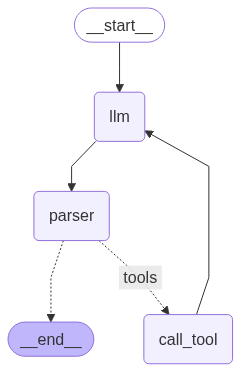

In [12]:
from IPython.display import display
import IPython.display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

IPython.display.display(
    IPython.display.Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [13]:
# Setup states for questions and run agent
answers_payload = []
results_log = []
#for r in range(len(hf_questions)):
for r in [0]:
  s = AgentState(question = hf_questions[r]['question'],
              input_file = hf_questions[r]['input_file'],
              file_type = hf_questions[r]['file_type'],
              file_path = hf_questions[r]['file_path'])
  try:
      task_id = hf_questions[r]['task_id']
      question_text = hf_questions[r]['question']
      full_answer = run_agent(s)
      submitted_answer = extract_final_answer(full_answer[-1].content)
      answers_payload.append({"task_id": task_id, "model_answer": submitted_answer})
      results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": submitted_answer})
  except:
      print(f"Error running agent on task {task_id}: {e}")
      results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": f"AGENT ERROR: {e}"})

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Loaded spaCy model: en_core_web_sm


<ipython-input-11-8ae1b562e033>:127: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self._embedding_model = HuggingFaceEmbeddings(model_name=self.embedding_model_name)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Running call_llm...
LLM call complete...
Running parse_react_output (Action prioritized)...
ReAct: Found Action: wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval, Input: '{"query": "Mercedes Sosa studio albums 2000-2009"}'
AIMessage updated with tool_calls: [{'name': 'wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval', 'args': {'query': 'Mercedes Sosa studio albums 2000-2009'}, 'id': '3d941c42-36e0-46b5-bef0-9903a2bc4203'}]
🔍 Analyzing message content: [SYSTEM] You are a general AI assistant. with access to these tools:

    wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval - Fetches content from multiple Wikipedia pages...
🔧 Found tool call format:
   Thought: <your thought>
   Action: <tool_name>
   Action Input: <tool_input>
🚀 Added tool call to state: {'thought': '<your thought>', 'action': '<tool_name>', 'action_input': '<tool_input>', 'normalized_action': '<tool_name>', 'tool_mapping': '<tool_

NameError: name 'e' is not defined

In [13]:
import re

# Test content from your actual message
content = '''[SYSTEM] You are a general AI assistant. with access to these tools:

 wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval - Fetches content from multiple Wikipedia pages based on intelligent NLP query processing of various search candidates, with strong prioritization of query entities. It then performs entity-focused semantic search across all fetched content to find the most relevant information, with improved retrieval for lists like discographies. Uses spaCy for named entity recognition and query enhancement. Input should be a search query or topic. Note: Uses the current live version of Wikipedia.
duckduckgo_search - A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.
youtube_screenshot_qa - Downloads a YouTube video, extracts screenshots at intervals, and answers a question about the video based on the screenshots. Input should be a dict with keys: 'youtube_url' and 'question'.Example input: {'youtube_url': 'https://www.youtube.com/watch?v=L1vXCYZAYYM', 'question': 'What is the highest number of bird species on camera simultaneously?'}

 If you can answer the question confidently, do so directly.
 If you need more information, use a tool.
 (Think through the problem step by step)

 When using a tool, follow this format:
 Thought: <your thought>
 Action: <tool_name>
 Action Input: <tool_input>

 Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].
 YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
 If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise.
 If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
 If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string
 Do not provide disclaimers.
 Do not provide supporting details.


[HUMAN] How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia. [ASSISTANT] Thought: I need to find out how many studio albums Mercedes Sosa published between 2000 and 2009. I will use the wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval tool to get information about her discography within that time frame.
Action: wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval
Action Input: {"query": "Mercedes Sosa studio albums 2000-2009"}'''

print("=== TESTING REGEX PATTERNS ===")

# Test different regex patterns
patterns = [
    (r"Action:\s*(.+?)(?:\n|$)", "Original action pattern"),
    (r"Action:\s*([^<\n]+?)(?:\n|$)", "Modified action pattern (no < or newline)"),
    (r"Action:\s*([^\n]+)", "Simple action pattern"),
    (r"Action:\s*(wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval)", "Exact tool name pattern")
]

for pattern, description in patterns:
    match = re.search(pattern, content)
    if match:
        print(f"{description}: FOUND -> '{match.group(1)}'")
    else:
        print(f"{description}: NOT FOUND")

print("\n=== TESTING ACTION INPUT PATTERNS ===")

input_patterns = [
    (r'Action Input:\s*(.*?)(?=\n\n|\nThought:|\nAction:|\nFINAL ANSWER:|\n\[|$)', "Original input pattern"),
    (r'Action Input:\s*({.*?})', "JSON input pattern"),
    (r'Action Input:\s*(.+?)(?=\n|$)', "Simple input pattern"),
]

for pattern, description in input_patterns:
    match = re.search(pattern, content, re.DOTALL)
    if match:
        print(f"{description}: FOUND -> '{match.group(1)}'")
    else:
        print(f"{description}: NOT FOUND")

print("\n=== FINDING ALL ACTION OCCURRENCES ===")
action_matches = list(re.finditer(r"Action:", content))
print(f"Found {len(action_matches)} occurrences of 'Action:'")

for i, match in enumerate(action_matches):
    start = match.start()
    end = min(start + 100, len(content))
    context = content[start:end].replace('\n', '\\n')
    print(f"  {i+1}. Position {start}: '{context}'")

=== TESTING REGEX PATTERNS ===
Original action pattern: FOUND -> '<tool_name>'
Modified action pattern (no < or newline): FOUND -> 'wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval'
Simple action pattern: FOUND -> '<tool_name>'
Exact tool name pattern: FOUND -> 'wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval'

=== TESTING ACTION INPUT PATTERNS ===
Original input pattern: FOUND -> '<tool_input>'
JSON input pattern: FOUND -> '{"query": "Mercedes Sosa studio albums 2000-2009"}'
Simple input pattern: FOUND -> '<tool_input>'

=== FINDING ALL ACTION OCCURRENCES ===
Found 2 occurrences of 'Action:'
  1. Position 1383: 'Action: <tool_name>\n Action Input: <tool_input>\n\n Report your thoughts, and finish your answer with '
  2. Position 2607: 'Action: wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval\nAction Input:'


In [ ]:
mywiki = WikipediaSearchToolWithFAISS()

In [ ]:
hf_questions[0]['question']

In [ ]:
foobar = mywiki.run(hf_questions[0]['question'])


In [ ]:
print(foobar)


In [ ]:
aaprint(full_answer[4].content)

In [ ]:
print(hf_questions[1]['question'])

In [ ]:
result = youtube_screenshot_qa_tool._run({
    "youtube_url": "https://www.youtube.com/watch?v=L1vXCYZAYYM",
    "question": "What is the highest number of bird species on camera simultaneously?"
})
print(result)

In [ ]:
myresponse = run_agent(hf_questions[0]['question'])
print(myresponse[-1].content)

In [ ]:
#foo = run_agent("Who is currently in first place in the American League Central in MLB?")
print(extract_final_answer(foo[-1].content))

In [ ]:
print(hf_questions[8]['question'])

In [ ]:
myresponse8= run_agent(hf_questions[8]['question'])
print(myresponse[-1].content)

In [ ]:
res = []
for j in range(len(hf_questions)):
    print(f"question {j}\n{hf_questions[j]['question']}")
    res.append(run_agent(hf_questions[j]['question']))
    print(extract_final_answer(res[j][-1].content))

In [ ]:
print(extract_final_answer(res[j][-1].content))

In [ ]:
print(hf_questions[0]['question'])

In [ ]:
aresponse[9].content


In [ ]:
print(aresponse[2].content)

In [ ]:
hf_questions[0]

In [ ]:
run_agent(hf_questions[0]['question'])
#run_agent("What was the main topic of the Wikipedia article on 'Artificial Intelligence' in the year 2020?")

In [ ]:
rag_question = hf_questions[0]['question']
retrieved_rag_docs = retrieve_documents_for_rag(rag_question, revision_year=2022)

In [ ]:
generate_answer_from_rag_context(rag_question, retrieved_rag_docs)

In [ ]:
import os
# Try to set this early, before PyTorch CUDA context is initialized
# This can help with memory fragmentation.
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import re
import gc
import uuid # For generating unique tool call IDs
from datetime import datetime
from langchain_core.tools import BaseTool, StructuredTool, tool
from typing import TypedDict, Annotated, List, Optional, Dict, Any, Literal, Union

import torch
import wikipedia
from transformers import pipeline, BitsAndBytesConfig # Added BitsAndBytesConfig for optional quantization

from langchain_core.messages import AIMessage, HumanMessage, AnyMessage, ToolMessage, SystemMessage
from langchain_core.tools import render_text_description
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_huggingface import HuggingFacePipeline

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

# --- Model Configuration ---
# Set this flag to True if you want to try 4-bit quantization
# You'll need to ensure 'bitsandbytes' and 'accelerate' are installed
USE_QUANTIZATION = True

def create_llm_pipeline():
    model_id = "meta-llama/Llama-2-13b-chat-hf"

    quantization_config = None
    if USE_QUANTIZATION:
        print("Using 4-bit quantization (BitsAndBytes)...")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16  # or torch.float16 if bfloat16 is not supported
        )

    model_kwargs = {}
    if quantization_config:
        model_kwargs["quantization_config"] = quantization_config
        # For quantized models, torch_dtype in pipeline() might conflict or be unnecessary
        # The compute_dtype is set in bnb_config.
        # We also let device_map handle dtype placement mostly.
    else:
        # Only specify torch_dtype if not using quantization that dictates compute_dtype
        model_kwargs["torch_dtype"] = torch.float16


    return pipeline(
        "text-generation",
        model=model_id,
        model_kwargs=model_kwargs,
        device_map="auto", # Handles model distribution and offloading
        max_new_tokens=512,
        temperature=0.1 # Passed to the pipeline for generation config
    )

# --- Agent State Definition ---
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], lambda x, y: x + y]
    done: bool = False

# --- Define Tools ---
class WikipediaSearchTool(BaseTool):
    name: str = "wikipedia"
    description: str = "Search Wikipedia for information about a query. Input should be a search query."

    def _run(self, query: str) -> str:
        try:
            print(f"Running wikipedia tool with query: '{query}'")
            page = wikipedia.page(query, auto_suggest=True)
            content = page.summary
            # Limit overall content to prevent overly long observations
            if len(content) < 300 and hasattr(page, 'content'):
                content += "\n\n" + page.content[:1500] # Get a bit more if summary is short
            return content[:2500] # Truncate final observation
        except wikipedia.exceptions.DisambiguationError as e:
            return f"Multiple matches found for '{query}'. Please be more specific. Options include: {', '.join(e.options[:3])}"
        except wikipedia.exceptions.PageError:
            results = wikipedia.search(query, results=3)
            if results:
                try:
                    page = wikipedia.page(results[0], auto_suggest=True)
                    return page.summary[:2500]
                except Exception as inner_e:
                    return f"No exact Wikipedia page found for '{query}'. Top search result '{results[0]}' could not be loaded: {str(inner_e)}. Other results: {', '.join(results[1:3])}"
            else:
                return f"No Wikipedia information found for '{query}'."
        except Exception as e:
            return f"Error searching Wikipedia for '{query}': {str(e)}"

wikipedia_tool = WikipediaSearchTool()
search_tool = DuckDuckGoSearchRun()
tools = [wikipedia_tool, search_tool]

# --- Define LLM Call and Parsing Logic ---
# Define how many messages to keep in context (excluding system prompt)
# System (1) + Human + AI(Action) + Observation + Human + AI(Action) + Observation + Human + AI(Final) = 8 dialogue messages
# This means MAX_DIALOGUE_MESSAGES should be around 6-8 for a couple of tool uses.
# Let's try 6 dialogue messages (System + 3 turns)
MAX_DIALOGUE_MESSAGES = 6

def call_llm(state: AgentState) -> AgentState:
    print("Running call_llm...")
    messages = state["messages"]
    prompt_parts = []

    system_message_content = None
    # Preserve the first message if it's a system prompt
    if messages and isinstance(messages[0], SystemMessage):
        system_message_content = messages[0].content
        dialogue_messages = messages[1:] # Messages for history window
    else:
        dialogue_messages = messages # Should not happen with current setup

    # Apply windowing to dialogue_messages
    if len(dialogue_messages) > MAX_DIALOGUE_MESSAGES:
        start_index = len(dialogue_messages) - MAX_DIALOGUE_MESSAGES
        dialogue_messages_to_use = dialogue_messages[start_index:]
        print(f"History truncated: Using last {len(dialogue_messages_to_use)} dialogue messages (plus system prompt).")
    else:
        dialogue_messages_to_use = dialogue_messages

    # Build the prompt
    if system_message_content:
        prompt_parts.append(system_message_content)

    for msg in dialogue_messages_to_use:
        if isinstance(msg, HumanMessage):
            prompt_parts.append(f"Human: {msg.content}")
        elif isinstance(msg, AIMessage):
            prompt_parts.append(f"AI: {msg.content}") # This content includes Thought/Action/Input
        elif isinstance(msg, ToolMessage):
            prompt_parts.append(f"Observation: {msg.content}")
        elif not isinstance(msg, SystemMessage): # Should not happen here
            prompt_parts.append(str(msg.content))

    formatted_input = "\n\n".join(prompt_parts)
    formatted_input += "\n\nAI: " # Prompt the AI to generate its response

    print(f"\n--- Input to LLM (length: {len(formatted_input)}) --- \n{formatted_input[:500]}...\n---------------------\n")

    raw_response_text = llm.invoke(formatted_input)
    print(f"\n--- Raw LLM Output (length: {len(raw_response_text)}) --- \n{raw_response_text[:500]}...\n----------------------\n")

    ai_generated_text = raw_response_text.strip()
    # Basic stripping if model echoes parts of the prompt.
    # A more robust way would be to know the exact prompt structure Llama-2 expects
    # and rely on the pipeline to only return the completion.
    # If the raw_response_text starts with the "AI: " we appended, strip it.
    if ai_generated_text.startswith("AI:"): # Check if our suffix is there
        ai_generated_text = ai_generated_text[len("AI:"):].strip()
    elif formatted_input.strip().endswith(ai_generated_text): # Unlikely, but handles full echo
         print("Warning: LLM echoed the entire input or produced empty output.")
         ai_generated_text = "" # Or handle as error

    ai_message = AIMessage(content=ai_generated_text)

    new_state = state.copy()
    new_state["messages"] = messages + [ai_message]
    new_state.pop("done", None)
    return new_state
def parse_react_output(state: AgentState) -> AgentState:
    print("Running parse_react_output (Action prioritized)...")
    messages = state["messages"]
    last_message = messages[-1]
    new_state = state.copy()

    if not isinstance(last_message, AIMessage):
        return new_state

    content = last_message.content

    # First, always check for Action patterns (prioritize tool calls)
    action_match = re.search(r"Action:\s*(.+?)(?:\n|$)", content)
    action_input_match = re.search(r"Action Input:\s*((?:.|\n)+?)(?=\n(?:Thought:|Action:|FINAL ANSWER:)|$)", content)

    if action_match and action_input_match:
        tool_name = action_match.group(1).strip()
        tool_input_raw = action_input_match.group(1).strip()

        print(f"ReAct: Found Action: {tool_name}, Input: '{tool_input_raw}'")

        # Handle different tool input formats
        tool_args = {}
        tool_name_lower = tool_name.lower()

        if tool_name_lower in ["wikipedia", "wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval"]:
            # Try to parse as JSON first, fallback to plain string
            try:
                import json
                parsed_input = json.loads(tool_input_raw)
                if isinstance(parsed_input, dict):
                    tool_args = parsed_input
                else:
                    tool_args = {"query": str(parsed_input)}
            except (json.JSONDecodeError, ValueError):
                tool_args = {"query": tool_input_raw}
        elif tool_name_lower == "duckduckgo_search":
            tool_args = {"query": tool_input_raw}
        elif tool_name_lower == "youtube_screenshot_qa":
            # Try to parse as JSON for youtube tool
            try:
                import json
                tool_args = json.loads(tool_input_raw)
            except (json.JSONDecodeError, ValueError):
                tool_args = {"input": tool_input_raw}
        else:
            print(f"Warning: Tool '{tool_name}' not explicitly handled for arg formatting. Assuming 'query'.")
            tool_args = {"query": tool_input_raw}

        tool_call_id = str(uuid.uuid4())
        parsed_tool_calls = [{"name": tool_name, "args": tool_args, "id": tool_call_id}]

        updated_ai_message = AIMessage(content=content, tool_calls=parsed_tool_calls)
        new_state["messages"] = messages[:-1] + [updated_ai_message]
        new_state.pop("done", None)
        print(f"AIMessage updated with tool_calls: {parsed_tool_calls}")
        return new_state

    # Only check for FINAL ANSWER if no Action was found
    # Look for FINAL ANSWER that appears to be an actual response (not in instructions)
    final_answer_pattern = r"FINAL ANSWER:\s*(.+?)(?:\n|$)"
    final_answer_matches = list(re.finditer(final_answer_pattern, content, re.IGNORECASE))

    if final_answer_matches:
        # Take the last occurrence of FINAL ANSWER (in case there are multiple)
        last_match = final_answer_matches[-1]

        # Check if this appears to be an actual answer (not just in the template/instructions)
        # Look for context clues that this is a real answer
        before_match = content[:last_match.start()]

        # If there's substantial content before the FINAL ANSWER and it looks like reasoning,
        # then this is likely a real final answer
        if len(before_match.strip()) > 100 or "Thought:" in before_match:
            final_answer_text = last_match.group(1).strip()
            final_answer_content = f"FINAL ANSWER: {final_answer_text}"

            # Ensure this AIMessage does not carry over any mistaken tool_calls
            updated_ai_message = AIMessage(content=final_answer_content, tool_calls=[])
            new_state["messages"] = messages[:-1] + [updated_ai_message]
            new_state["done"] = True
            print(f"FINAL ANSWER found: '{final_answer_text}'")
            return new_state

    print("No parseable Action or genuine FINAL ANSWER found in LLM output. Marking as done.")
    new_state["done"] = True
    return new_state

# --- Graph Construction ---
workflow = StateGraph(AgentState)
workflow.add_node("llm", call_llm)
workflow.add_node("parser", parse_react_output)
workflow.add_node("call_tool", call_tool)

workflow.set_entry_point("llm")
workflow.add_edge("llm", "parser")
workflow.add_conditional_edges(
    "parser",
    tools_condition,
    {"tools": "call_tool", "__end__": END}
)
workflow.add_edge("call_tool", "llm")
agent = workflow.compile()

# --- Global LLM and Pipeline ---
hf_pipe = None
llm = None

# --- Run the Agent ---
def run_agent(query: str):
    global llm, hf_pipe, agent # Ensure agent is also global if recompiled based on USE_QUANTIZATION

    print(f"Initializing LLM pipeline for query: '{query}' (Quantization: {USE_QUANTIZATION})")
    # If USE_QUANTIZATION changes, we might want to re-initialize/recompile
    # For simplicity, assume it's set once at the start.
    if hf_pipe is None or llm is None:
        hf_pipe = create_llm_pipeline()
        llm = HuggingFacePipeline(pipeline=hf_pipe)
        # Recompile agent if pipeline changes significantly, e.g. due to quantization settings.
        # agent = workflow.compile() # If agent structure depends on llm instance specifics
        print("LLM and pipeline initialized.")
    else:
        print("LLM and pipeline already initialized.")

    formatted_tools_description = render_text_description(tools)
    system_content = f"""You are a helpful AI assistant. You have access to the following tools:

{formatted_tools_description}

When you decide to use a tool, you MUST format your response for that turn *exactly* as follows, and *nothing else*:
Thought: <your reasoning for using the tool and choosing the input>
Action: <tool_name>
Action Input: <the input to the tool>
(Your response for this turn MUST end here if you are calling a tool. Do NOT add any other text, reflections, or 'FINAL ANSWER:' after the Action Input if you are using a tool.)

After the tool is executed, you will receive an Observation. You should then use this observation to continue your thought process, call another tool, or provide your final answer.

If you can answer the question directly without tools, or if you have gathered enough information from tools and are ready to give the answer, your response for that turn MUST be formatted *exactly* as follows, and *nothing else*:
FINAL ANSWER: <your final answer>

Begin!
"""

    human_message = HumanMessage(content=query)
    system_message = SystemMessage(content=system_content)

    initial_state: AgentState = {
        "messages": [system_message, human_message],
        "done": False
    }

    print(f"Initial state messages for agent.invoke: {[m.type for m in initial_state['messages']]}")

    final_result_state = agent.invoke(initial_state) # Add config to show intermediate steps if needed

    print(f"\n--- Final Result State from Agent ---")
    if final_result_state:
        for msg_idx, msg in enumerate(final_result_state.get("messages", [])):
            print(f"Message {msg_idx} [{msg.type}]:")
            content_to_print = msg.content
            if len(content_to_print) > 300:
                content_to_print = content_to_print[:300] + "..."
            print(f"  Content: {content_to_print}")
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                print(f"  Tool Calls: {msg.tool_calls}")
        print(f"Done flag: {final_result_state.get('done')}")

    return final_result_state.get("messages", []) if final_result_state else []


if __name__ == '__main__':
    # To use quantization, set USE_QUANTIZATION = True at the top of the script.
    # Make sure 'bitsandbytes' and 'accelerate' are installed:
    # pip install bitsandbytes accelerate

    print(f"PYTORCH_CUDA_ALLOC_CONF: {os.environ.get('PYTORCH_CUDA_ALLOC_CONF')}")

    queries = [
        "Tell me about the Eiffel Tower using Wikipedia.",
        #"What is the current weather in New York City?",
        #"What is 10 + 17 * 3?",
        # This query is longer and involves multiple steps, good for testing context limits
        #"Who is the current president of France? After finding that, what is the capital of France according to Wikipedia?"
    ]

    for i, q in enumerate(queries):
        print(f"\n\n--- Test {i+1}: Query: '{q}' ---")
        try:
            run_agent(q)
        except Exception as e:
            print(f"An error occurred during run_agent for query '{q}': {e}")
            if "out of memory" in str(e).lower():
                print("CUDA Out of Memory error occurred. Suggestions:")
                print("1. Reduce MAX_DIALOGUE_MESSAGES further (currently {}).".format(MAX_DIALOGUE_MESSAGES))
                print("2. Set USE_QUANTIZATION = True at the top of the script (requires 'bitsandbytes' and 'accelerate').")
                print("3. Ensure no other processes are using significant GPU memory.")
                # Optionally, try to release memory here if continuing
                if llm or hf_pipe:
                    del llm; del hf_pipe; llm=None; hf_pipe=None
                    gc.collect()
                    if torch.cuda.is_available(): torch.cuda.empty_cache()
        print("-------------------------------------------------------------------\n")

    # Final cleanup
    if llm or hf_pipe:
        del llm
        del hf_pipe
        llm = None
        hf_pipe = None
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("Manually cleaned up LLM, pipeline, and cleared CUDA cache.")

PYTORCH_CUDA_ALLOC_CONF: expandable_segments:True


--- Test 1: Query: 'Tell me about the Eiffel Tower using Wikipedia.' ---
Initializing LLM pipeline for query: 'Tell me about the Eiffel Tower using Wikipedia.' (Quantization: True)
Using 4-bit quantization (BitsAndBytes)...


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

In [ ]:
# Example: User asks a question about a recent event
user_question = "Who won the 2025 UEFA Champions League final?"

state = {
    "messages": [HumanMessage(content=user_question)],
    "tool_output": None
}

# Run the agent
result = re_agent.invoke(state)

# Print the agent's response
print(result["messages"][-1].content)

In [ ]:

qnum = 9
s = State(question = hf_questions[qnum]['question'],
            input_file = hf_questions[qnum]['input_file'],
            file_type = hf_questions[qnum]['file_type'],
            file_path = hf_questions[qnum]['file_path'])
temp_ans = intelligent_agent(s)
final_ans = extract_final_answer(temp_ans)
print(final_ans)

In [ ]:
print(temp_ans)

In [ ]:
print(temp_ans)

In [ ]:
hf_questions[0]['question']

In [ ]:
foo

In [ ]:
len(final_ans)

In [ ]:
full_ans = []
model_answers = []
reasoning_trace = []
for qnum in range(len(hf_questions)):
  s = State(question = hf_questions[qnum]['question'],
            input_file = hf_questions[qnum]['input_file'],
            file_type = hf_questions[qnum]['file_type'],
            file_path = hf_questions[qnum]['file_path'])
  print(f"s['question'] {qnum}")
  temp_ans = intelligent_agent(s)
  full_ans.append(temp_ans)
  temp_ans, reasoning = split_final_answer(temp_ans)
  model_answers.append(temp_ans)
  reasoning_trace.append(reasoning)
  print(temp_ans)


## Older code

In [ ]:

def call_tool(state: AgentState) -> AgentState:
    """Process tool calls from the AI and return results."""
    print("Running call_tool...")
    messages = state["messages"]
    last_message = messages[-1]

    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        # No tool calls found, return unchanged
        return state

    # Copy the messages to avoid mutating the list during iteration
    new_messages = list(messages)

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        args = tool_call["args"]

        # Find the matching tool
        selected_tool = None
        for tool in tools:
            if tool.name.lower() == tool_name.lower():
                selected_tool = tool
                break

        if not selected_tool:
            tool_result = f"Error: Tool '{tool_name}' not found. Available tools: {', '.join(t.name for t in tools)}"
        else:
            try:
                # Extract the query argument for search tools
                if isinstance(args, dict) and "query" in args:
                    query = args["query"]
                else:
                    query = str(args)

                tool_result = selected_tool._run(query)
                if len(tool_result) > 6000:
                    tool_result = tool_result[:6000] + "... [Result truncated due to length]"
            except Exception as e:
                tool_result = f"Error executing tool '{tool_name}': {str(e)}"

        tool_call_id = str(uuid.uuid4())
        tool_message = ToolMessage(
            content=tool_result,
            name=tool_name,
            tool_call_id=tool_call_id
        )
        new_messages.append(tool_message)

    # Update the state in-place
    state["messages"] = new_messages
    return state


In [ ]:


def run_agent(user_query: str):
    """
    Main agent loop: initializes state, runs ReAct loop, and ensures GPU memory is freed at the end.
    Stops after the first FINAL ANSWER.
    """
    # Initial state: system prompt + user message
    state = {
        "messages": [
            HumanMessage(content=system_message_template),  # system prompt
            HumanMessage(content=user_query)
        ],
        "done": False
    }

    print("Initializing run_agent....")


    try:
        while not state["done"]:
            print("Running ReAct loop...")
            # 1. LLM step
            llm_result = call_llm(state)
            state["messages"] = llm_result["messages"]

            # 2. Parse LLM output for tool usage or final answer
            parse_result = parse_react_output(state)
            state["messages"] = parse_result["messages"]
            state["done"] = parse_result.get("done", False)

            # 3. If tool_calls present, execute tool and append ToolMessage
            last_ai_msg = state["messages"][-1]
            tool_calls = getattr(last_ai_msg, "tool_calls", None)
            if tool_calls and not state["done"]:
                for tool_call in tool_calls:
                    tool_name = tool_call["name"]
                    tool_args = tool_call["args"]
                    tool_id = tool_call["id"]
                    # Find the tool by name
                    tool = next((t for t in tools if t.name == tool_name), None)
                    if tool:
                        clear_gpu_memory()
                        tool_output = tool.run(tool_args["query"])
                        clear_gpu_memory()
                        state["messages"].append(
                            ToolMessage(
                                content=tool_output,
                                tool_call_id=tool_id
                            )
                        )
    finally:
        clear_gpu_memory()

    # Print or return the final answer
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage) and "FINAL ANSWER:" in msg.content:
            print(msg.content)
            return msg.content
    print("No final answer found.")
    return None


In [ ]:

# This is the central system prompt that guides the LLM's ReAct behavior.
# It asks the LLM to output "Thought:", then "Action:" and "Action Input:", or "FINAL ANSWER:".
# The Qwen Coder model might need careful prompting to stick to this exact format.
# If it deviates, the `parse_react_output` node will fail.
old_system_message_template = f"""You are a helpful AI assistant with access to the following tools:

{formatted_tools_description}

To use a tool, you MUST use the following format strictly:
Thought: [Your thought process on why you need to use a tool and which one]
Action: [The exact name of the tool to use, e.g., DuckDuckGoSearch or WikipediaSearch]
Action Input: [The input string for the tool]

You should use your own knowledge to answer questions if you are confident in the answer.
Only use a tool if you do not know the answer or if you need up-to-date or very specific information.

If you know the answer, respond with:
Thought: [Your thought process on why you know the answer]
FINAL ANSWER: [Your answer]

If you need to use a tool, respond with:
Thought: [Your thought process on why you need to use a tool and which one]
Action: [The exact name of the tool to use, e.g., DuckDuckGoSearch or WikipediaSearch]
Action Input: [The input string for the tool]

Thought: [Your thought process on why you have enough information]
FINAL ANSWER: [Your final answer to the user's original question]

The current date is {current_date_str}.

Begin!
"""



In [ ]:
import os
import re
import cv2
import shutil
import glob
import librosa
import numpy as np
import torch
import gc
from PIL import Image
from collections import Counter
from typing import TypedDict, List, Optional, Dict, Any, Literal, Tuple
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    pipeline
)
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langgraph.graph import StateGraph, START, END

# Set PyTorch memory management options
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

try:
    import yt_dlp
except ImportError:
    print("yt_dlp not installed. Video functionality will be limited.")

try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
except ImportError:
    print("spaCy not installed. Using regex-based entity extraction as fallback.")
    nlp = None

# Global memory management function
def clear_gpu_memory():
    """Clear GPU cache and run garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# 1. Define the State type
class State(TypedDict, total=False):
    question: str
    task_id: str
    input_file: Optional[bytes]
    file_type: Optional[str]
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]
    next: Optional[str]  # Added to track the next node
    llm_prompt: Optional[str]  # Added to handle custom prompts between nodes

# --- Initialize models with memory management ---
def get_optimal_device():
    """Get optimal device based on available memory"""
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory
        free_memory = torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)
        print(f"GPU Memory: {free_memory/1024**3:.2f}GB free of {total_memory/1024**3:.2f}GB total")

        # If less than 2GB free, use CPU
        if free_memory < 2 * 1024**3:
            return "cpu"
        else:
            return "cuda:0"
    else:
        return "cpu"

# --- LLM pipeline with lazy initialization ---
_llm_pipe = None

# --- LLM pipeline with improved memory efficiency ---
def get_llm_pipeline():
    """Get LLM pipeline with lazy initialization and proper quantization"""
    global _llm_pipe

    if _llm_pipe is None:
        print("Initializing LLM pipeline...")
        clear_gpu_memory()

        try:
            # First try with 8-bit quantization on GPU
            if torch.cuda.is_available():
                print("Loading 8-bit quantized model on GPU")
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="auto",
                    model_kwargs={
                        "load_in_8bit": True,  # Enable 8-bit quantization
                        "torch_dtype": torch.float16,
                    },
                    max_new_tokens=256
                )
                print("Successfully loaded 8-bit quantized model on GPU")
            else:
                print("No GPU available, loading model on CPU")
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="cpu",
                    max_new_tokens=256
                )
        except (ImportError, RuntimeError) as e:
            # If 8-bit loading fails (missing dependencies or other issues)
            print(f"8-bit loading failed: {e}. Trying 4-bit quantization...")
            try:
                # Try with 4-bit quantization
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="auto",
                    model_kwargs={
                        "load_in_4bit": True,
                        "bnb_4bit_compute_dtype": torch.float16,
                    },
                    max_new_tokens=256
                )
                print("Successfully loaded 4-bit quantized model on GPU")
            except (ImportError, RuntimeError) as e:
                # If all GPU options fail, fall back to CPU
                print(f"GPU loading failed: {e}. Falling back to CPU...")
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="cpu",
                    max_new_tokens=256
                )

    return _llm_pipe

# --- Speech-to-text pipeline with lazy loading ---
_asr_pipe = None

def get_asr_pipeline():
    """Get ASR pipeline with lazy initialization"""
    global _asr_pipe

    if _asr_pipe is None:
        print("Initializing ASR pipeline...")
        # Always use CPU for ASR to save GPU memory
        _asr_pipe = pipeline(
            "automatic-speech-recognition",
            model="openai/whisper-small",
            device=-1
        )

    return _asr_pipe

# --- BLIP VQA setup with memory management ---
#device = get_optimal_device()
device = "cpu"
print(f"Using device: {device} for vision models")

vqa_model_name = "Salesforce/blip-vqa-base"
processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)

# Attempt to load model with memory management
try:
    model_vqa = BlipForQuestionAnswering.from_pretrained(
        vqa_model_name,
        torch_dtype=torch.float16 if device != "cpu" else torch.float32,
        low_cpu_mem_usage=True
    ).to(device)
except torch.cuda.OutOfMemoryError:
    print("WARNING: Loading vision model to CPU due to insufficient GPU memory.")
    device = "cpu"  # Switch device to CPU
    model_vqa = BlipForQuestionAnswering.from_pretrained(
        vqa_model_name,
        low_cpu_mem_usage=True
    ).to(device)

def extract_entities(text: str) -> List[str]:
    """Extract key entities from text using spaCy if available, or regex fallback"""
    if nlp:
        # Using spaCy for better entity extraction
        doc = nlp(text)
        entities = [ent.text for ent in doc.ents]
        keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]
        return entities if entities else keywords
    else:
        # Simple fallback using regex to extract potential keywords
        words = text.lower().split()
        stopwords = ["what", "who", "when", "where", "why", "how", "is", "are", "the", "a", "an", "of", "in", "on", "at"]
        keywords = [word for word in words if word not in stopwords and len(word) > 2]
        return keywords

def answer_question_on_frame(image_path, question):
    """Answer a question about a single video frame using BLIP with memory management"""
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor_vqa(image, question, return_tensors="pt").to(device)

        # Run inference with reduced memory usage
        with torch.inference_mode(), torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            out = model_vqa.generate(**inputs)

        answer = processor_vqa.decode(out[0], skip_special_tokens=True)

        # Clean up
        del inputs, out
        clear_gpu_memory()

        return answer
    except Exception as e:
        print(f"Error processing frame {image_path}: {str(e)}")
        return "Error processing this frame"

def answer_video_question(frames_dir, question):
    """Answer a question about a video by analyzing extracted frames with memory management"""
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    # Limit the number of frames to analyze to save memory
    max_frames = 10
    if len(frame_files) > max_frames:
        # Take frames evenly distributed
        step = len(frame_files) // max_frames
        frame_files = frame_files[::step][:max_frames]
        print(f"Limited analysis to {len(frame_files)} frames to save memory")

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
            clear_gpu_memory()  # Clear memory after each frame
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }

def download_youtube_video(url, output_dir='/tmp/video/', output_filename='downloaded_video.mp4'):
    """Download a YouTube video using yt-dlp"""
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    try:
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': output_path,
            'quiet': True,
            'merge_output_format': 'mp4',  # Ensures merged output is mp4
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  # Recode if needed
            }]
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        return output_path
    except Exception as e:
        print(f"Error downloading YouTube video: {str(e)}")
        return None

def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    """Extract frames from a video file at specified intervals"""
    # Clean output directory before extracting new frames
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)

        # Increase frame interval to reduce memory usage
        frame_interval = int(fps * frame_interval_seconds * 2)  # Double the interval

        count = 0
        saved = 0
        max_frames = 12  # Limit total frames saved

        while True and saved < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1

        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def image_qa(image_path: str, question: str) -> str:
    """Answer questions about an image using the BLIP model with memory management"""
    clear_gpu_memory()

    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor_vqa(image, question, return_tensors="pt").to(device)

        with torch.inference_mode(), torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            out = model_vqa.generate(**inputs)

        answer = processor_vqa.decode(out[0], skip_special_tokens=True)

        # Clean up
        del inputs, out
        clear_gpu_memory()

        return answer
    except Exception as e:
        print(f"Error in image_qa: {str(e)}")
        return f"Error processing image: {str(e)}"

# --- Node functions ---
def router(state: Dict[str, Any]) -> str:
    """Determine the next node based on question content and file type"""
    question = state.get('question', '')

    # Pattern for Wikipedia and similar sources
    wiki_pattern = r"(wikipedia\.org|wiki|encyclopedia|britannica\.com|encyclop[a|æ]dia)"
    has_wiki = re.search(wiki_pattern, question, re.IGNORECASE) is not None

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, question) is not None

    # Check for image
    has_image = state.get('file_type') == 'picture'

    # Check for audio
    has_audio = state.get('file_type') == 'audio'

    print(f"Has Wikipedia reference: {has_wiki}")
    print(f"Has YouTube link: {has_youtube}")
    print(f"Has picture file: {has_image}")
    print(f"Has audio file: {has_audio}")

    if has_wiki:
        return "retrieve"
    elif has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", question)
        if url_match:
            state['youtube_url'] = url_match.group(0)
        return "video"
    elif has_image:
        return "image"
    elif has_audio:
        return "audio"
    else:
        return "llm"

def node_decide(state: Dict[str, Any]) -> Dict[str, Any]:
    """Router node that decides which node to go to next"""
    print("Running node_decide")
    # Initialize context list if not present
    if 'context' not in state:
        state['context'] = []
    # Add the next state to the state dict
    state["next"] = router(state)
    print(f"Routing to: {state['next']}")
    return state

def node_image(state: Dict[str, Any]) -> Dict[str, Any]:
    """Process image-based questions with memory management"""
    print("Running node_image")
    clear_gpu_memory()

    try:
        # Make sure the image file exists
        if not os.path.exists(state['file_path']):
            state['answer'] = "Image file not found."
            return state

        # Get answer from image QA model
        answer = image_qa(state['file_path'], state['question'])

        # Format the final answer
        state['answer'] = answer

        # Add document to state for traceability
        image_doc = Document(
            page_content=f"Image analysis result: {answer}",
            metadata={"source": "image_analysis", "file_path": state['file_path']}
        )
        state['context'].append(image_doc)

        clear_gpu_memory()

    except Exception as e:
        error_msg = f"Error processing image: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    return state

def node_video(state: Dict[str, Any]) -> Dict[str, Any]:
    """Process video-based questions with memory management"""
    print("Running node_video")
    clear_gpu_memory()

    youtube_url = state.get('youtube_url')
    if not youtube_url:
        state['answer'] = "No YouTube URL found in the question."
        return state

    question = state['question']
    # Extract the actual question part (remove the URL)
    question_text = re.sub(r'https?://[^\s]+', '', question).strip()
    if not question_text.endswith('?'):
        question_text += '?'

    video_file = download_youtube_video(youtube_url)
    if not video_file or not os.path.exists(video_file):
        state['answer'] = "Failed to download the video."
        return state

    frames_dir = "/tmp/frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Extract frames with increased interval to reduce memory usage
    success = extract_frames(video_path=video_file, output_dir=frames_dir, frame_interval_seconds=20)
    if not success:
        state['answer'] = "Failed to extract frames from the video."
        return state

    result = answer_video_question(frames_dir, question_text)
    final_answer = result['most_common_answer']

    # Store only a limited number of frame answers to save memory
    max_frame_answers = 5
    if len(result['all_answers']) > max_frame_answers:
        state['frame_answers'] = result['all_answers'][:max_frame_answers]
    else:
        state['frame_answers'] = result['all_answers']

    # Create Document objects for a limited number of frame analyses
    frame_documents = []
    for i, ans in enumerate(result['all_answers'][:max_frame_answers]):
        doc = Document(
            page_content=f"Frame {i}: {ans}",
            metadata={"frame_number": i, "source": "video_analysis"}
        )
        frame_documents.append(doc)

    # Add documents to state
    state['context'].extend(frame_documents)
    state['answer'] = final_answer

    print(f"Video answer: {state['answer']}")

    # Clean up video files to save disk space
    try:
        if os.path.exists(video_file):
            os.remove(video_file)
        # Remove frame files
        for file in os.listdir(frames_dir):
            file_path = os.path.join(frames_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    except Exception as e:
        print(f"Error cleaning up files: {e}")

    clear_gpu_memory()
    return state

def node_audio_rag(state: Dict[str, Any]) -> Dict[str, Any]:
    """Process audio-based questions (RAG style, LLM called only in LLM node)"""
    print(f"Processing audio file: {state['file_path']}")
    clear_gpu_memory()

    try:
        # Step 1: Transcribe audio
        audio, sr = librosa.load(state['file_path'], sr=16000)

        # Get ASR pipeline
        asr_pipe = get_asr_pipeline()

        asr_result = asr_pipe({"raw": audio, "sampling_rate": sr})
        audio_transcript = asr_result['text']
        print(f"Audio transcript: {audio_transcript}")

        # Clean up audio data
        del audio
        clear_gpu_memory()

        # Step 2: Store transcript in vector store
        transcript_doc = [Document(page_content=audio_transcript)]

        # Use lightweight embeddings with CPU
        embeddings = HuggingFaceEmbeddings(
            model_name='BAAI/bge-large-en-v1.5',
            model_kwargs={"device": "cpu"}
        )

        vector_db = FAISS.from_documents(transcript_doc, embedding=embeddings)

        # Step 3: Retrieve relevant docs for the user's question
        question = state['question']
        similar_docs = vector_db.similarity_search(question, k=1)
        retrieved_context = "\n".join([doc.page_content for doc in similar_docs])

        # Step 4: Prepare prompt (do NOT call LLM here)
        prompt = (
            f"You are an AI assistant that answers questions about audio content.\n\n"
            f"Audio transcript: {retrieved_context}\n\n"
            f"Question: {question}\n\n"
            f"Based only on the provided audio transcript, answer the question. "
            f"If the transcript does not contain relevant information, state that clearly.\n\n"
              "Format your answer using these rules:\n"
              "   - Numbers: Plain digits without commas/units (e.g. 1234567)\n"
              "   - Strings: Minimal words, no articles/abbreviations\n"
              "   - Lists: comma-separated values without extra formatting\n\n"
            f"End your response with 'FINAL ANSWER: ' followed by a concise answer."
            f"For example, the question is 'how many seasons are in a year' reply with FINAL ANSWER: 4"
        )

        # Add transcript and prompt as Documents to context
        state['context'].extend(transcript_doc)
        state['context'].append(Document(
            page_content=prompt,
            metadata={"source": "audio_analysis_prompt"}
        ))

        # Pass the prompt to the LLM node via state
        state['llm_prompt'] = prompt
        state["next"] = "llm"  # Ensure pipeline routes to LLM node next

        # Clean up
        del vector_db, embeddings
        clear_gpu_memory()

    except Exception as e:
        error_msg = f"Error processing audio: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg
        state["next"] = "end"

    return state

def node_llm(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Generate answer using LLM based on context and question with memory management.
    Uses a custom prompt from state['llm_prompt'] if available,
    otherwise constructs the default prompt.
    """
    print("Running node_llm")
    clear_gpu_memory()

    try:
        # Use custom prompt if provided by previous node
        if 'llm_prompt' in state and state['llm_prompt']:
            prompt = state['llm_prompt']
        else:
            # Build default prompt from context and question
            # Limit context to avoid OOM
            context_text = ""

            for doc in state.get('context', []):
                context_text += "\n\n" + doc.page_content

            prompt = (
                "You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.\n"
                f"Context:\n{context_text}\n\n"
                f"Question: {state['question']}\n\n"
            )

        # Get LLM pipeline
        llm_pipe = get_llm_pipeline()

        # Call the LLM pipeline with optimized settings
        try:
            llm_response = llm_pipe(
                prompt,
                max_new_tokens=512,  # Reduced for memory efficiency
                temperature=0.2,     # More focused responses
                num_return_sequences=1
            )
            answer_text = llm_response[0]['generated_text']
        except torch.cuda.OutOfMemoryError:
            # Fallback to CPU processing if GPU OOM occurs
            print("LLM GPU OOM error, falling back to CPU processing")
            clear_gpu_memory()

            # Simplified prompt
            short_prompt = (
                f"Question: {state['question']}\n"
                f"Answer this concisely and end with FINAL ANSWER:"
            )

            from transformers import AutoTokenizer, AutoModelForCausalLM

            model_id = "meta-llama/Llama-3.1-8B-Instruct"
            tokenizer = AutoTokenizer.from_pretrained(model_id)
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map="cpu",
                low_cpu_mem_usage=True
            )

            inputs = tokenizer(short_prompt, return_tensors="pt")
            with torch.no_grad():
                output = model.generate(inputs["input_ids"], max_new_tokens=100)
            answer_text = tokenizer.decode(output[0], skip_special_tokens=True)

            # Clean up CPU model
            del model, tokenizer

        state['answer'] = answer_text

    except Exception as e:
        error_msg = f"Error generating answer: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    # Final cleanup
    clear_gpu_memory()

    return state

# --- Wikipedia Loader ---
class WikipediaLoader:
    def __init__(self, query, lang="en", revision=None, load_max_docs=1,
                 doc_content_chars_max=300000, load_all_available_meta=True):
        self.query = query
        self.lang = lang
        self.revision = revision
        self.load_max_docs = load_max_docs
        self.doc_content_chars_max = doc_content_chars_max
        self.load_all_available_meta = load_all_available_meta

    def load(self):
        """Load Wikipedia content with revision support"""
        import wikipedia
        from datetime import datetime
        wikipedia.set_lang(self.lang)

        try:
            # First get current page to find page ID
            page = wikipedia.page(self.query)

            # Get specific revision if requested
            if self.revision:
                # Handle year-based requests (e.g., "2022 version")
                if isinstance(self.revision, int) and len(str(self.revision)) == 4:
                    revision_date = datetime(self.revision, 12, 31)  # Get last revision of year
                    rev_id = self._get_revision_by_date(page.pageid, revision_date)
                else:
                    rev_id = self.revision

                content = self._get_revision_content(page.pageid, rev_id)
            else:
                content = page.content

            content = content[:self.doc_content_chars_max]

            metadata = {
                "title": page.title,
                "source": page.url,
                "revision": rev_id if self.revision else "current"
            }

            return [Document(page_content=content, metadata=metadata)]

        except Exception as e:
            print(f"Error loading Wikipedia content: {e}")
            return []

    def _get_revision_by_date(self, pageid, target_date):
        import requests
        url = f"https://{self.lang}.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "prop": "revisions",
            "pageids": pageid,
            "rvlimit": 1,
            "rvdir": "older",
            "rvstart": target_date.isoformat(),
            "format": "json"
        }
        response = requests.get(url, params=params).json()
        pages = response.get("query", {}).get("pages", {})
        page = pages.get(str(pageid), {})
        revisions = page.get("revisions", [])
        if not revisions:
            raise ValueError(f"No revisions found for pageid {pageid} on {target_date}")
        return revisions[0]["revid"]

    def _get_revision_content(self, pageid, rev_id):
        import requests
        url = f"https://{self.lang}.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "prop": "revisions",
            "revids": rev_id,
            "rvprop": "content",
            "format": "json"
        }
        response = requests.get(url, params=params).json()
        pages = response.get("query", {}).get("pages", {})
        page = pages.get(str(pageid), {})
        revisions = page.get("revisions", [])
        if not revisions:
            raise ValueError(f"No revision content found for pageid {pageid} and revision {rev_id}")
        rev = revisions[0]
        if "*" in rev:
            return rev["*"]
        elif "slots" in rev and "main" in rev["slots"] and "*" in rev["slots"]["main"]:
            return rev["slots"]["main"]["*"]
        else:
            raise ValueError("Could not find revision content in API response")

def retrieve(state: dict) -> dict:
    """Retrieve Wikipedia content with revision support (including 2022 version if requested)"""
    print("Running retrieve node")
    clear_gpu_memory()

    question = state["question"]

    # 1. Detect revision year from question
    revision_year = None
    if "version" in question.lower() or "wikipedia" in question.lower():
        import re
        # Look for a year (e.g., '2022') near 'version' or 'wikipedia'
        year_match = re.search(r'(20\d{2})\s*(version|wikipedia)', question.lower())
        if not year_match:
            # fallback: any 4-digit year
            year_match = re.search(r'(20\d{2})', question)
        if year_match:
            revision_year = int(year_match.group(1))
    # Default to 2022 if user explicitly says "latest 2022 version"
    if not revision_year and "2022" in question and "wikipedia" in question.lower():
        revision_year = 2022

    # 2. Entity extraction logic
    entities = extract_entities(question)
    if "Mercedes Sosa" in question:
        query = "Mercedes Sosa"
    elif entities:
        person_entities = [e for e in entities if "Mercedes Sosa" in e or "Sosa" in e]
        query = person_entities[0] if person_entities else " ".join(entities)
    else:
        query = question

    try:
        loader = WikipediaLoader(
            query=query,
            revision=revision_year,
            load_max_docs=3,
            doc_content_chars_max=300000
        )
        docs = loader.load()

        # Existing splitting logic
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk, metadata=doc.metadata)
                               for chunk in chunks])

        state['context'] = all_chunks
        print(f"Retrieved {len(all_chunks)} chunks (revision: {revision_year or 'current'})")

    except Exception as e:
        print(f"Retrieval error: {e}")
        state['context'] = []
        state['answer'] = (f"Error: {str(e)}")

    clear_gpu_memory()
    return state



def generate(state: dict) -> dict:
    """Generate an answer based on retrieved documents with memory management"""
    print("Running generate")
    clear_gpu_memory()

    try:
        # Limit context size to prevent OOM
        docs_content = ""
        for doc in state.get("context", []):
            docs_content += "\n\n" + doc.page_content

        # Simplified prompt for memory efficiency
        prompt_str = (
            #"You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.\n"
            "You are a general AI assistant. I will ask you a question. Report your thoughts concisely, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.\n"
            "If you are asked for a number, just give the number\n"
            f"Answer this question based on context:\n{docs_content}\n\n"
            f"Question: {state['question']}\n"
        )

        # Get the LLM pipeline using the shared function - this already handles GPU/CPU selection
        llm_pipe = get_llm_pipeline()

        # Try main pipeline with optimized parameters
        try:
            response = llm_pipe(
                prompt_str,
                max_new_tokens=150,
                temperature=0.3
            )
            answer_text = response[0]["generated_text"]
        except torch.cuda.OutOfMemoryError:
            # Fallback to CPU if GPU fails
            clear_gpu_memory()
            print("Falling back to CPU for text generation")

            # Use the same model as defined in get_llm_pipeline but force CPU
            from transformers import AutoTokenizer, AutoModelForCausalLM

            model_id = "meta-llama/Llama-3.1-8B-Instruct"  # Use the same model as in get_llm_pipeline
            tokenizer = AutoTokenizer.from_pretrained(model_id)

            # Use optimal device selection based on available resources
            device_map = get_optimal_device()
            print(f"Fallback using device: {device_map}")

            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map=device_map,
                torch_dtype=torch.float16 if device_map.startswith("cuda") else torch.float32,
                low_cpu_mem_usage=True
            )

            inputs = tokenizer(prompt_str, return_tensors="pt").to(device_map)
            with torch.inference_mode(), torch.cuda.amp.autocast(enabled=device_map.startswith("cuda")):
                output = model.generate(inputs["input_ids"], max_new_tokens=100)
            answer_text = tokenizer.decode(output[0], skip_special_tokens=True)
            del model, tokenizer, inputs, output  # Clean up

        # Format answer
        state['answer'] = answer_text
        clear_gpu_memory()  # Final cleanup

    except Exception as e:
        print(f"Error in generate node: {str(e)}")
        state['answer'] = f"Error generating answer: {str(e)}"

    return state


# --- Define the edge condition function ---
def get_next_node(state: Dict[str, Any]) -> str:
    """Get the next node from the state"""
    return state["next"]

# Create the StateGraph
graph = StateGraph(State)

# Add nodes
graph.add_node("decide", node_decide)
graph.add_node("video", node_video)
graph.add_node("llm", node_llm)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("image", node_image)
graph.add_node("audio", node_audio_rag)

# Add edge from START to decide
graph.add_edge(START, "decide")
graph.add_edge("retrieve", "generate")

# Add conditional edges from decide to other nodes based on question
graph.add_conditional_edges(
    "decide",
    get_next_node,
    {
        "video": "video",
        "llm": "llm",
        "retrieve": "retrieve",
        "image": "image",
        "audio": "audio"
    }
)

# Add edges from all terminal nodes to END
graph.add_edge("video", END)
graph.add_edge("llm", END)
graph.add_edge("generate", END)
graph.add_edge("image", END)
graph.add_edge("audio", END)

# Compile the graph
agent = graph.compile()

# --- Intelligent Agent Function ---
def intelligent_agent(state: State) -> str:
    """Process a question using the appropriate pipeline based on content."""
    try:
        # Ensure state has proper structure
        if not isinstance(state, dict):
            return "FINAL ANSWER: Error - input must be a valid State dictionary"

        # Make sure question exists
        if 'question' not in state:
            return "FINAL ANSWER: Error - question is required"

        # Initialize context if not present
        if 'context' not in state:
            state['context'] = []

        print(f"Processing question: {state['question']}")

        # Invoke the agent with the state
        final_state = agent.invoke(state)

        # Ensure answer has FINAL ANSWER format
        answer = final_state.get('answer', "No answer found.")

        return answer

    except Exception as e:
        print(f"Error in agent execution: {str(e)}")
        return f"FINAL ANSWER: An error occurred - {str(e)}"



In [ ]:
os.getcwd()

In [ ]:
"""
import os
import re
from PIL import Image  # This is correctly imported, but was being used incorrectly
import numpy as np
from collections import Counter
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline
from typing import TypedDict, List, Optional, Dict, Any, Literal, Tuple
from langgraph.graph import StateGraph, START, END
from langchain.docstore.document import Document

# 1. Define the State type
class State(TypedDict, total=False):
    question: str
    task_id: str
    input_file: bytes
    file_type: str
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]
    next: Optional[str]  # Added to track the next node

# --- LLM pipeline for general questions ---
llm_pipe = pipeline("text-generation",
                    #model="meta-llama/Llama-3.3-70B-Instruct",
                    #model="meta-llama/Meta-Llama-3-8B-Instruct",
                    #model="Qwen/Qwen2-7B-Instruct",
                    #model="microsoft/Phi-4-reasoning",
                    model="microsoft/Phi-3-mini-4k-instruct",
                    device_map="auto",
                    #device_map={ "": 0 },  # "" means the whole model
                    #max_memory={0: "10GiB"},
                    torch_dtype="auto",
                    max_new_tokens=256)


tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-base")
retriever = RagRetriever.from_pretrained(
    "facebook/rag-token-base",
    index_name="exact",           # or "legacy" for legacy FAISS index
    use_dummy_dataset=True,        # set to False and download the full index for real Wikipedia retrieval
    trust_remote_code=True
)
rag_model = RagSequenceForGeneration.from_pretrained("facebook/rag-token-base", retriever=retriever)

# Speech-to-text pipeline
asr_pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=-1
    #device_map={"", 0},
    #max_memory = {0: "4.5GiB"},
    #device_map="auto"
)

# --- Your BLIP VQA setup ---
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
vqa_model_name = "Salesforce/blip-vqa-base"
processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)

# Attempt to load model to GPU; fall back to CPU if OOM
try:
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)
except torch.cuda.OutOfMemoryError:
    print("WARNING: Loading model to CPU due to insufficient GPU memory.")
    device = "cpu"  # Switch device to CPU
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)


# --- Helper: Answer question on a single frame ---
def answer_question_on_frame(image_path, question):
    # Fixed: Properly use the PIL Image module
    image = Image.open(image_path).convert('RGB')
    inputs = processor_vqa(image, question, return_tensors="pt").to(device)
    out = model_vqa.generate(**inputs)
    answer = processor_vqa.decode(out[0], skip_special_tokens=True)
    return answer

# --- Helper: Answer question about the whole video ---
def answer_video_question(frames_dir, question):
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }


def download_youtube_video(url, output_dir='/tmp/video/', output_filename='downloaded_video.mp4'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': output_path,
        'quiet': True,
        'merge_output_format': 'mp4',  # Ensures merged output is mp4
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4',  # Recode if needed
        }]
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_path



# --- Helper: Extract frames from video ---
def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    # --- Clean output directory before extracting new frames ---
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_interval_seconds)
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1
        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def image_qa(image_path: str, question: str, model_name: str = vqa_model_name) -> str:
    """
    Answers questions about images using Hugging Face's VQA pipeline.

    Args:
        image_path: Path to local image file or URL
        question: Natural language question about the image
        model_name: Pretrained VQA model (default: good general-purpose model)

    Returns:
        str: The model's best answer
    """
    # Create VQA pipeline with specified model
    vqa_pipeline = pipeline("visual-question-answering", model=model_name)

    # Get predictions (automatically handles local files/URLs)
    results = vqa_pipeline(image=image_path, question=question, top_k=1)

    # Return top answer
    return results[0]['answer']


def router(state: Dict[str, Any]) -> str:
    """Determine the next node based on whether the question contains a YouTube URL or references Wikipedia."""
    question = state.get('question', '')


    # Pattern for Wikipedia and similar sources
    wiki_pattern = r"(wikipedia\.org|wiki|encyclopedia|britannica\.com|encyclop[a|æ]dia)"
    has_wiki = re.search(wiki_pattern, question, re.IGNORECASE) is not None

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, question) is not None

    # Check for image
    has_image = state.get('file_type') == 'picture'

    # Check for audio
    has_audio = state.get('file_type') == 'audio'

    print(f"Has Wikipedia reference: {has_wiki}")
    print(f"Has YouTube link: {has_youtube}")
    print(f"Has picture file: {has_image}")
    print(f"Has audio file: {has_audio}")

    if has_wiki:
        return "retrieve"
    elif has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", question)
        if url_match:
            state['youtube_url'] = url_match.group(0)
        return "video"
    elif has_image:
        return "image"
    elif has_audio:
        return "audio"
    else:
        return "llm"


# --- Node Implementation ---
def node_image(state: Dict[str, Any]) -> Dict[str, Any]:
  """Router node that decides which node to go to next."""
  print("Running node_image")
  # Add the next state to the state dict
  img = Image.open(state['file_path'])
  state['answer'] = image_qa(state['file_path'], state['question'])
  return state


def node_decide(state: Dict[str, Any]) -> Dict[str, Any]:
    """Router node that decides which node to go to next."""
    print("Running node_decide")
    # Add the next state to the state dict
    state["next"] = router(state)
    print(f"Routing to: {state['next']}")
    return state

def node_video(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_video")
    youtube_url = state.get('youtube_url')
    if not youtube_url:
        state['answer'] = "No YouTube URL found in the question."
        return state

    question = state['question']
    # Extract the actual question part (remove the URL)
    question_text = re.sub(r'https?://[^\s]+', '', question).strip()
    if not question_text.endswith('?'):
        question_text += '?'

    video_file = download_youtube_video(youtube_url)
    if not video_file or not os.path.exists(video_file):
        state['answer'] = "Failed to download the video."
        return state

    frames_dir = "/tmp/frames"
    os.makedirs(frames_dir, exist_ok=True)

    success = extract_frames(video_path=video_file, output_dir=frames_dir, frame_interval_seconds=10)
    if not success:
        state['answer'] = "Failed to extract frames from the video."
        return state

    result = answer_video_question(frames_dir, question_text)
    state['answer'] = result['most_common_answer']
    state['frame_answers'] = result['all_answers']

    # Create Document objects for each frame analysis
    frame_documents = []
    for i, ans in enumerate(result['all_answers']):
        doc = Document(
            page_content=f"Frame {i}: {ans}",
            metadata={"frame_number": i, "source": "video_analysis"}
        )
        frame_documents.append(doc)

    # Add documents to state if not already present
    if 'context' not in state:
        state['context'] = []
    state['context'].extend(frame_documents)

    print(f"Video answer: {state['answer']}")
    return state

def node_audio_rag(state: Dict[str, Any]) -> Dict[str, Any]:
    print(f"Processing audio file: {state['file_path']}")

    try:
        # Step 1: Transcribe audio
        audio, sr = librosa.load(state['file_path'], sr=16000)
        asr_result = asr_pipe({"raw": audio, "sampling_rate": sr})
        audio_transcript = asr_result['text']
        print(f"Audio transcript: {audio_transcript}")

        # Step 2: Store ONLY the transcript in the vector store
        transcript_doc = [Document(page_content=audio_transcript)]
        embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')
        vector_db = FAISS.from_documents(transcript_doc, embedding=embeddings)

        # Step 3: Retrieve relevant docs for the user's question
        question = state['question']
        similar_docs = vector_db.similarity_search(question, k=1)  # Only one doc in store
        retrieved_context = "\n".join([doc.page_content for doc in similar_docs])

        # Step 4: Augment prompt and generate answer
        prompt = (
            f"Use the following context to answer the question.\n"
            f"Context:\n{retrieved_context}\n\n"
            f"Question: {question}\nAnswer:"
        )
        llm_response = llm_pipe(prompt)
        state['answer'] = llm_response[0]['generated_text']

    except Exception as e:
        error_msg = f"Audio processing error: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    return state

def node_llm(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_llm")
    question = state['question']

    # Compose a detailed prompt following your requirements
    prompt = (
        "You are an AI assistant that answers questions using your general knowledge. "
        "Follow these steps:\n\n"
        "1. If the question appears to be scrambled or jumbled, first try to unscramble or reconstruct the intended meaning of the question.\n"
        "2. Analyze the question (unscrambled if needed) and use your own knowledge to answer it.\n"
        "3. If the question can't be answered with certainty, provide your best estimate and clearly explain any assumptions or reasoning you use.\n"
        "4. Format your answer using these rules:\n"
        "   - Numbers: Plain digits without commas/units (e.g. 1234567)\n"
        "   - Strings: Minimal words, no articles/abbreviations\n"
        "   - Lists: comma-separated values without extra formatting\n\n"
        "5. Always conclude with:\n"
        "FINAL ANSWER: [your answer] (replace bracketed text)\n\n"
        f"Current question: {question}"
    )

    # Add document to state for traceability
    query_doc = Document(
        page_content=prompt,
        metadata={"source": "llm_prompt"}
    )
    if 'context' not in state:
        state['context'] = []
    state['context'].append(query_doc)

    try:
        result = llm_pipe(prompt)
        state['answer'] = result[0]['generated_text']
    except Exception as e:
        print(f"Error in LLM processing: {str(e)}")
        state['answer'] = f"An error occurred while processing your question: {str(e)}"

    print(f"LLM answer: {state['answer']}")
    return state


# --- Define the edge condition function ---
def get_next_node(state: Dict[str, Any]) -> str:
    """Get the next node from the state."""
    return state["next"]


# 2. Improved Wikipedia Retrieval Node
def extract_keywords(question: str) -> List[str]:
    doc = nlp(question)
    keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]  # Extract proper nouns and nouns
    return keywords

def extract_entities(question: str) -> List[str]:
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    return entities if entities else [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]


def retrieve(state: dict) -> dict:
    question = state["question"]

    # Tokenize the question
    inputs = tokenizer(question, return_tensors="pt")

    # First, get the doc_ids by using the retriever directly
    question_hidden_states = rag_model.question_encoder(inputs["input_ids"])[0]
    docs_dict = retriever(
        inputs["input_ids"].numpy(),
        question_hidden_states.detach().numpy(),
        return_tensors="pt"
    )

    # Extract the retrieved passages
    all_chunks = []

    # Access the retrieved document texts from the docs_dict
    for i in range(len(docs_dict["doc_ids"][0])):
        doc_text = docs_dict["retrieved_doc_text"][0][i]
        all_chunks.append({"page_content": doc_text})

    print("Routing to: generate")
    return {"context": all_chunks}

def retrieve_old(state: State) -> dict:
    keywords = extract_entities(state["question"])
    query = " ".join(keywords)
    search_results = wikipedia.search(query)
    selected_page = search_results[0] if search_results else None

    if selected_page:
        loader = WikipediaLoader(
            query=selected_page,
            lang="en",
            load_max_docs=1,
            doc_content_chars_max=100000,
            load_all_available_meta=True
        )
        docs = loader.load()
        # Chunk the article for finer retrieval
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk) for chunk in chunks])
        # Optionally: re-rank or filter chunks here
        print("Routing to: generate")
        return {"context": all_chunks}
    else:
        print("Routing to: generate")
        return {"context": []}

# 3. Prompt Template for General QA
prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=(
        "You are an AI assistant that answers questions using Wikipedia context. "
        "Follow these steps:\n\n"
        "1. Analyze the provided Wikipedia context:\n{context}\n\n"
        "2. If the context contains scrambled text, first attempt to reconstruct meaningful information from it\n"
        "3. If the question can't be answered from context alone, combine context with general knowledge "
        "but clearly state this limitation\n"
        "4. Format your answer using these rules:\n"
        "   - Numbers: Plain digits without commas/units (e.g. 1234567)\n"
        "   - Strings: Minimal words, no articles/abbreviations\n"
        "   - Lists: comma-separated values without extra formatting\n\n"
        "5. Always conclude with:\n"
        "FINAL ANSWER: [your answer] (replace bracketed text)\n\n"
        "Current question: {question}"
    )
)

def generate(state: dict) -> dict:
    # Concatenate all context documents into a single string
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # Format the prompt for the LLM
    prompt_str = prompt.format(question=state["question"], context=docs_content)
    # Generate answer using Hugging Face pipeline
    response = llm_pipe(prompt_str)
    # Extract generated text
    answer = response[0]["generated_text"]
    return {"answer": answer}

# Create the StateGraph
graph = StateGraph(State)

# Add nodes
graph.add_node("decide", node_decide)
graph.add_node("video", node_video)
graph.add_node("llm", node_llm)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("image", node_image)
graph.add_node("audio", node_audio_rag)

# Add edge from START to decide
graph.add_edge(START, "decide")
graph.add_edge("retrieve", "generate")

# Add conditional edges from decide to video or llm based on question
graph.add_conditional_edges(
    "decide",
    get_next_node,
    {
        "video": "video",
        "llm": "llm",
        "retrieve": "retrieve",
        "image": "image",
        "audio": "audio"
    }
)

# Add edges from video and llm to END to terminate the graph
graph.add_edge("video", END)
graph.add_edge("llm", END)
graph.add_edge("generate", END)
graph.add_edge("image", END)
graph.add_edge("audio", END)

# Compile the graph
agent = graph.compile()

# --- Usage Example ---
def intelligent_agent(state: State) -> str:
    "Process a question using the appropriate pipeline based on content."
    #state = State(question= question)
    try:
        final_state = agent.invoke(state)
        return final_state.get('answer', "No answer found.")
    except Exception as e:
        print(f"Error in agent execution: {str(e)}")
        return f"An error occurred: {str(e)}"

# --- Try it! ---
# Test with a YouTube question
#question = "What are the people doing in https://www.youtube.com/watch?v=YTR21os8gTA ?"
#print(intelligent_agent(questions[3]))

#question = "What are the people doing in https://www.youtube.com/watch?v=WDJ-mhWluJY ?"
#print(intelligent_agent(question))
"""